# Sprawozdanie - MOwNiT - laboratorium 4., zadanie 1.

### Wersja bez animacji - do wyświetlania na GitHubie

#### Autor: Jakub Psarski

## Aproksymacja TSP z wykorzystaniem symulowanego wyżarzania

Wygeneruj chmurę n losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.
- Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema różnymi grupami parametrów, dziewięć odseparowanych grup punktów).
- Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap vs. arbitrary swap) oraz funkcji zmiany temperatury na zbieżność procesu optymalizacji.
- Przedstaw wizualizację działania procedury minimalizującej funkcję celu.

### 1. Importowanie potrzebnych bibliotek

In [1]:
import copy
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from matplotlib import animation, rcParams

rcParams['animation.embed_limit'] = 200

### 2. Implementacja algorytmu symulowanego wyżarzania dla TSP

In [2]:
def simulated_annealing(
        points, temperature=100, temp_function=lambda x, _: x*0.995, threshold=1e-2, swap_type="arbitrary"
    ):
    """Solve TSP using simulated annealing."""
    point_amount = len(points)
    dist_matrix = distance_matrix(points)

    current_path = list(range(point_amount))
    random.shuffle(current_path)
    current_length = path_length(current_path, dist_matrix)

    initial_path = copy.deepcopy(current_path)
    initial_length = current_length

    best_path = copy.deepcopy(current_path)
    best_length = current_length
    found_time = t_0 = time.perf_counter()

    lengths = [(0, initial_length)]
    temps = [(0, temperature)]
    paths = [copy.deepcopy(initial_path)]

    while temperature > threshold:
        for _ in range(100):
            match swap_type:
                case "consecutive":
                    i = random.randint(0, point_amount - 2)
                    j = i + 1
                case "arbitrary":
                    i, j = random.sample(range(point_amount), 2)

            current_path[i], current_path[j] = current_path[j], current_path[i]
            new_length = path_length(current_path, dist_matrix)

            if new_length < current_length or random.random() < math.exp((current_length - new_length) / temperature):
                current_length = new_length

                if new_length < best_length:
                    best_path = copy.deepcopy(current_path)
                    best_length = new_length
                    found_time = time.perf_counter() - t_0

            else:
                current_path[i], current_path[j] = current_path[j], current_path[i]

            paths.append(copy.deepcopy(current_path))

            lengths.append((time.perf_counter() - t_0, current_length))

        timestamp = time.perf_counter() - t_0
        temperature = temp_function(temperature, timestamp)
        temps.append((timestamp, temperature))

    return best_path, best_length, found_time, initial_path, initial_length, lengths, temps, paths


### 3. Funkcje pomocnicze

- `generate_points()` - generowanie chmury punktów zgodnie z podanymi parametrami

In [3]:
def generate_points(n, distribution="uniform"):
    """Generate n random points in 2D space with a given distribution."""
    match distribution:
        case "uniform":
            return np.random.rand(n, 2) * 100
        case "normal":
            centers = [(25, 25), (25, 75), (75, 25), (75, 75)]
            points = []
            for _ in range(n):
                center = random.choice(centers)
                points.append(np.random.normal(loc=center, scale=5, size=(1, 2))[0])
            return np.array(points)
        case "clusters":
            clusters = [(10, 10), (90, 90), (10, 90), (90, 10), (50, 50), (25, 75), (75, 25), (25, 25), (75, 75)]
            points = []
            for _ in range(n):
                cluster = random.choice(clusters)
                points.append(np.random.normal(loc=cluster, scale=2, size=(1, 2))[0])
            return np.array(points)

- `distance_matrix()` - generowanie macierzy zawierającej odległości między każdą parą punktów

In [4]:
def distance_matrix(points):
    """Compute the distance matrix for given points."""
    point_amount = len(points)
    dist_matrix = np.zeros((point_amount, point_amount))
    for i in range(point_amount):
        for j in range(point_amount):
            dist_matrix[i, j] = np.linalg.norm(points[i] - points[j])
    return dist_matrix

- `path_length()` - obliczanie długości danej drogi na podstawie macierzy odległości (funkcja kosztu)

In [5]:
def path_length(path, dist_matrix):
    """Calculate the total length of a given path."""
    return sum(dist_matrix[path[i], path[i + 1]] for i in range(len(path) - 1)) + dist_matrix[path[-1], path[0]]

- `plot_path()`, `plot_length()`, `plot_temperature()`, `plot_results()` - wizualizacja wyników oraz parametrów

In [6]:
def plot_path(ax, points, path, title):
    """Plot the given TSP path."""
    ordered_points = np.array([points[i] for i in path] + [points[path[0]]])
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(ordered_points[:, 0], ordered_points[:, 1], 'bo-')
    ax.scatter(points[:, 0], points[:, 1], c='red')


def plot_length(ax, lengths, title):
    """Plot the path lengths over iterations."""
    x_values, y_values = zip(*lengths)
    ax.plot(x_values, y_values, color='green', lw=0.5)
    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Path length")


def plot_temperature(ax, temps, title):
    """Plot the temperature over iterations."""
    x_values, y_values = zip(*temps)
    ax.plot(x_values, y_values, color='red', lw=1)
    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Temperature")


def plot_results(
        points, best_path, best_length, found_time, initial_path, initial_length, lengths, temps, n, dist, swap_type
    ):
    """Plot the results of the TSP simulation."""
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"TSP solution for n={n}, distribution: {dist}, swap type: {swap_type}", fontsize=16)

    plot_path(axs[0, 0], points, initial_path, title=f"Initial path: length = {initial_length:.2f}")
    plot_path(axs[0, 1], points, best_path,
              title=f"After annealing: length = {best_length:.2f}, found in {found_time:.2f}s")
    plot_length(axs[1, 0], lengths, title="Path length over time")
    plot_temperature(axs[1, 1], temps, title="Temperature over time")

    plt.show()

- `animate()` - animacja procesu wyżarzania na grafie

In [7]:
def animate(paths, points, best, pos, framerate=30):
    """Create an animation of the TSP solution."""
    best_path = None
    best_length = float('inf')

    def update(frame):
        nonlocal best_path, best_length

        dist_matrix = distance_matrix(points)
        current_length = path_length(frame, dist_matrix)

        if current_length < best_length:
            best_length = current_length
            best_path = copy.deepcopy(frame)

        ax.clear()
        ax.set_title(f"Current length: {current_length:.2f}, Best length: {best_length:.2f}")
        ax.set_xticks([])
        ax.set_yticks([])

        if best_path:
            short_x = [points[x][0] for x in best_path] + [points[best_path[0]][0]]
            short_y = [points[x][1] for x in best_path] + [points[best_path[0]][1]]
            ax.plot(short_x, short_y, color='green', linewidth=5, alpha=0.5, label="Best path")

        x_values = [points[x][0] for x in frame] + [points[frame[0]][0]]
        y_values = [points[x][1] for x in frame] + [points[frame[0]][1]]

        ax.scatter(x_values, y_values, color='red')
        ax.plot(x_values, y_values, color='blue', linewidth=0.5, label="Current path")
        ax.legend()

    fig, ax = plt.subplots(figsize=(8, 8))
    step = len(paths) // 200
    fr = paths[::step]
    fr[int(pos * 200)] = copy.deepcopy(best)    # to make sure the best path is included in the animation sample

    anim = animation.FuncAnimation(
        fig, update, frames=fr, interval=1000//framerate, repeat=False
    )

    plt.close(fig)

    return HTML(anim.to_html5_video())

### 4. Wyniki, czasy działania, wizualizacja

#### 4.1. Porównanie sposobów generacji sąsiedniego stanu, animacje

---------- n = 20 ----------

Distribution: uniform, swap type: arbitrary
Initial path length: 935.97
Best path length: 388.29, found in 1.05s
Total elapsed time: 2.83s


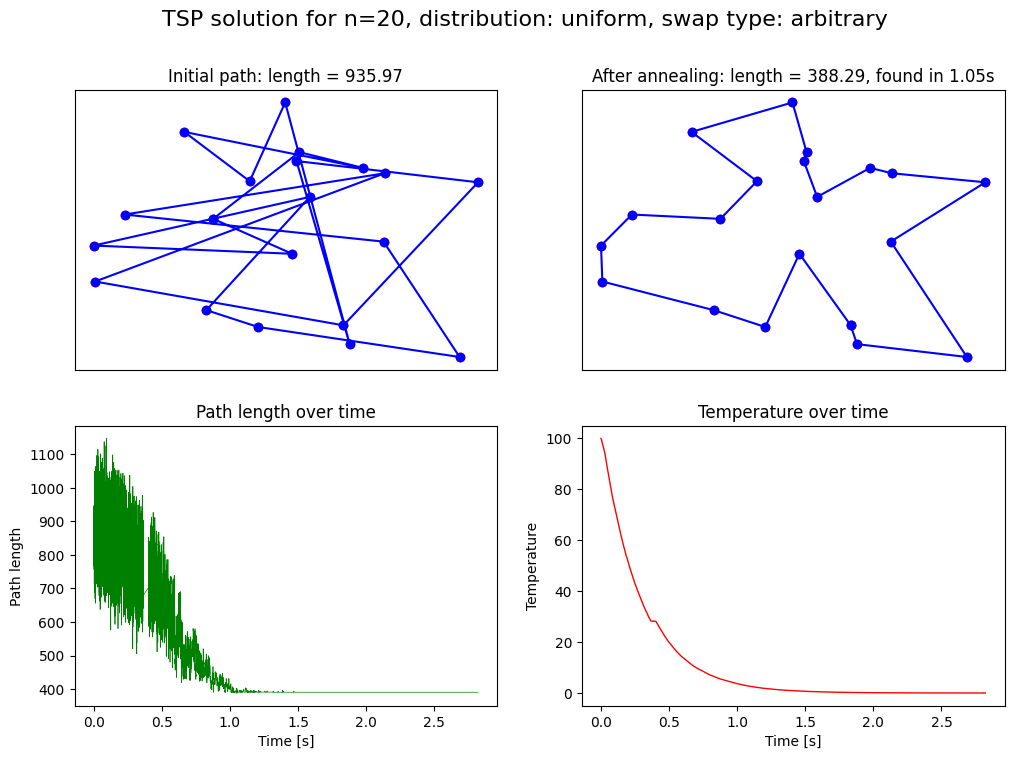

Distribution: uniform, swap type: consecutive
Initial path length: 880.12
Best path length: 519.59, found in 0.38s
Total elapsed time: 2.48s


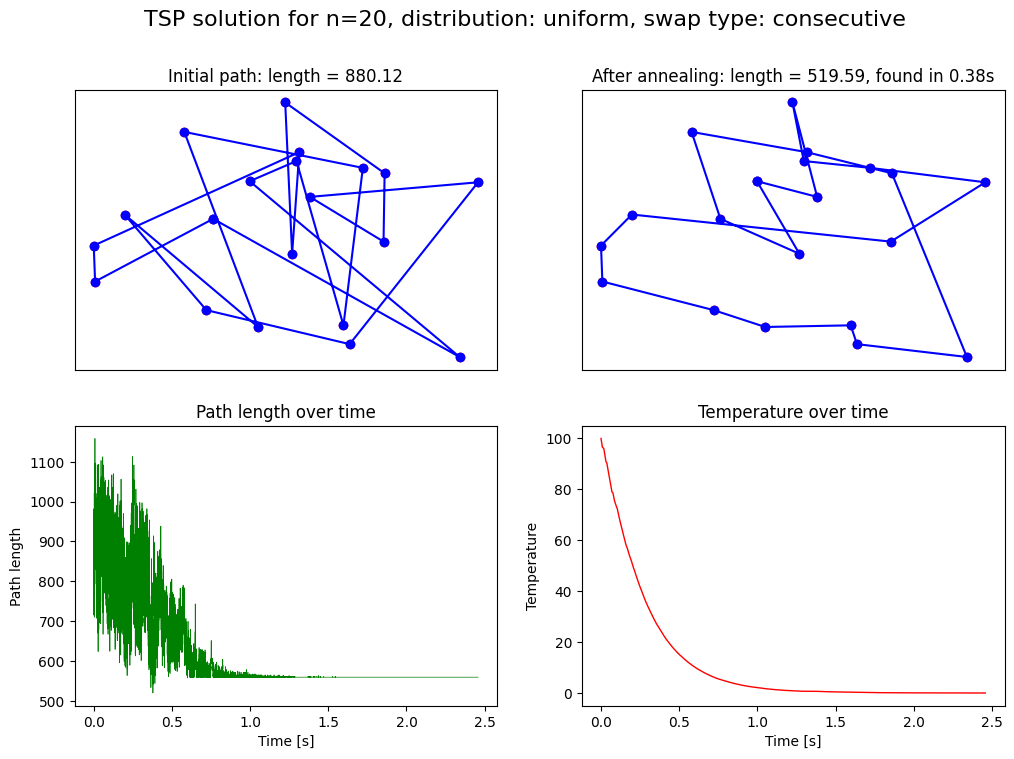

Shortest path comparison for different swap types:
arbitrary: 388.29
consecutive: 519.59

--------------------

Distribution: normal, swap type: arbitrary
Initial path length: 814.94
Best path length: 269.28, found in 1.26s
Total elapsed time: 3.08s


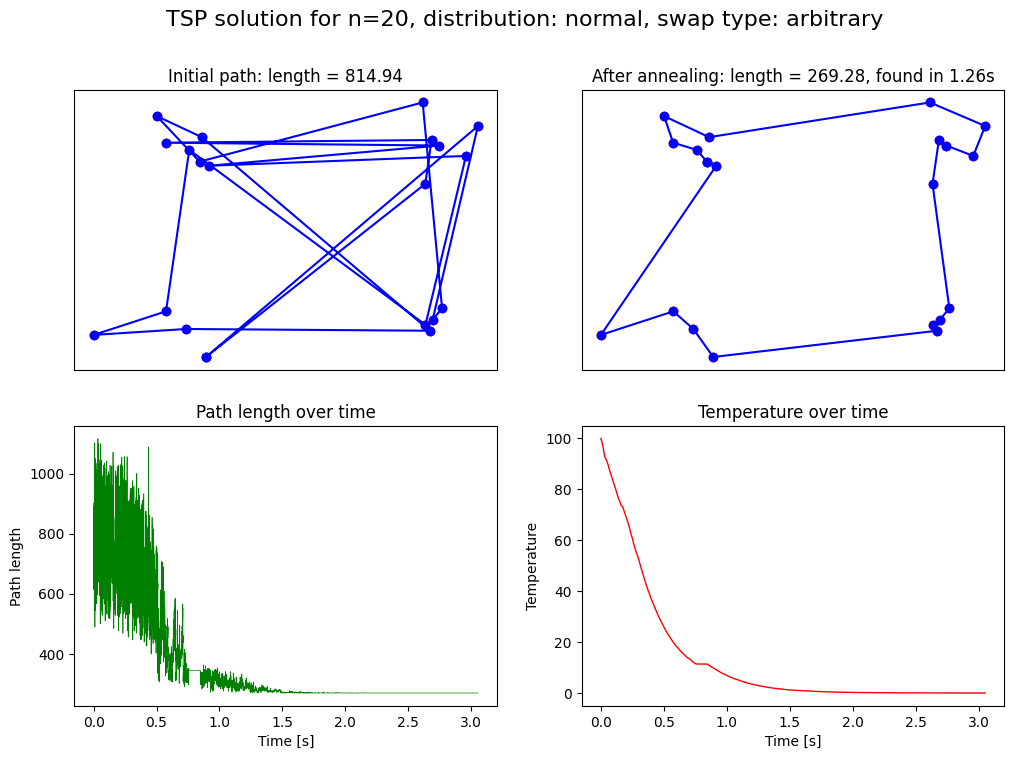

Distribution: normal, swap type: consecutive
Initial path length: 861.60
Best path length: 374.39, found in 0.37s
Total elapsed time: 2.51s


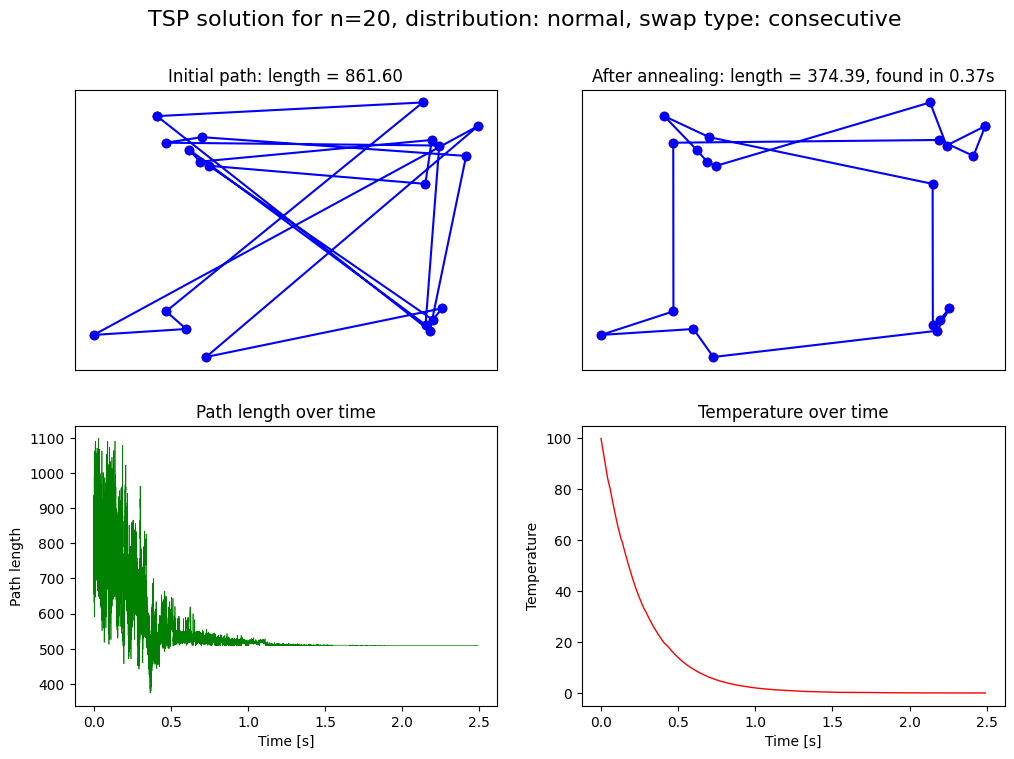

Shortest path comparison for different swap types:
arbitrary: 269.28
consecutive: 374.39

--------------------

Distribution: clusters, swap type: arbitrary
Initial path length: 870.04
Best path length: 354.66, found in 1.35s
Total elapsed time: 2.75s


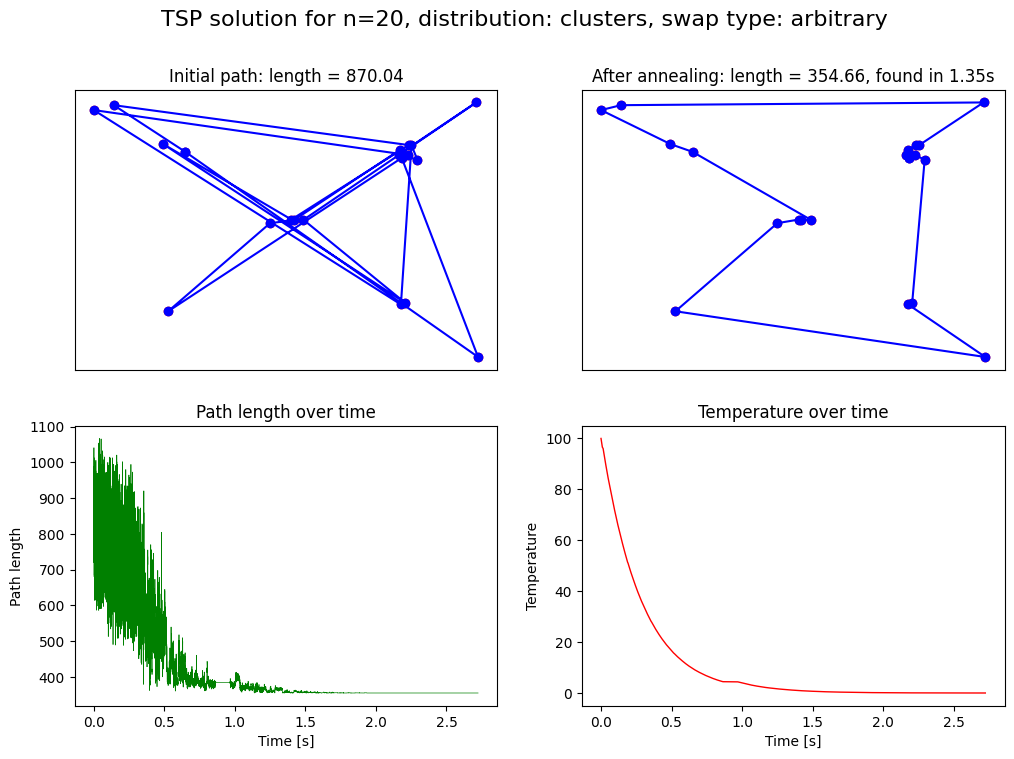

Distribution: clusters, swap type: consecutive
Initial path length: 795.08
Best path length: 355.48, found in 1.03s
Total elapsed time: 2.50s


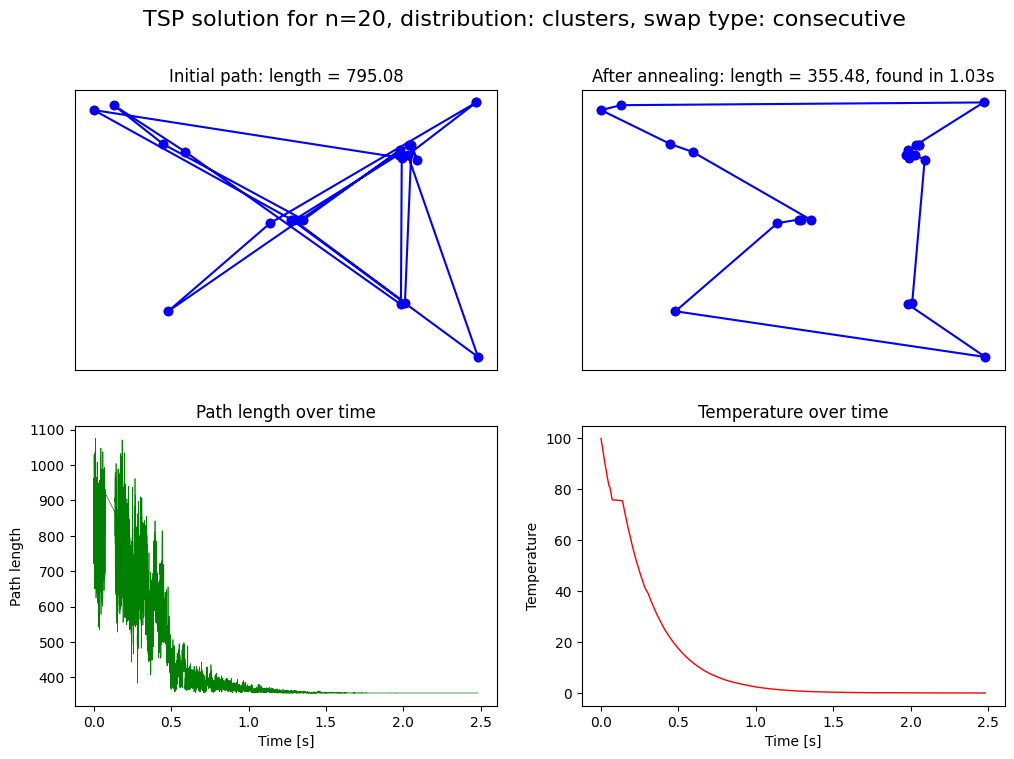

Shortest path comparison for different swap types:
arbitrary: 354.66
consecutive: 355.48

---------- n = 50 ----------

Distribution: uniform, swap type: arbitrary
Initial path length: 2492.78
Best path length: 681.42, found in 2.99s
Total elapsed time: 5.48s


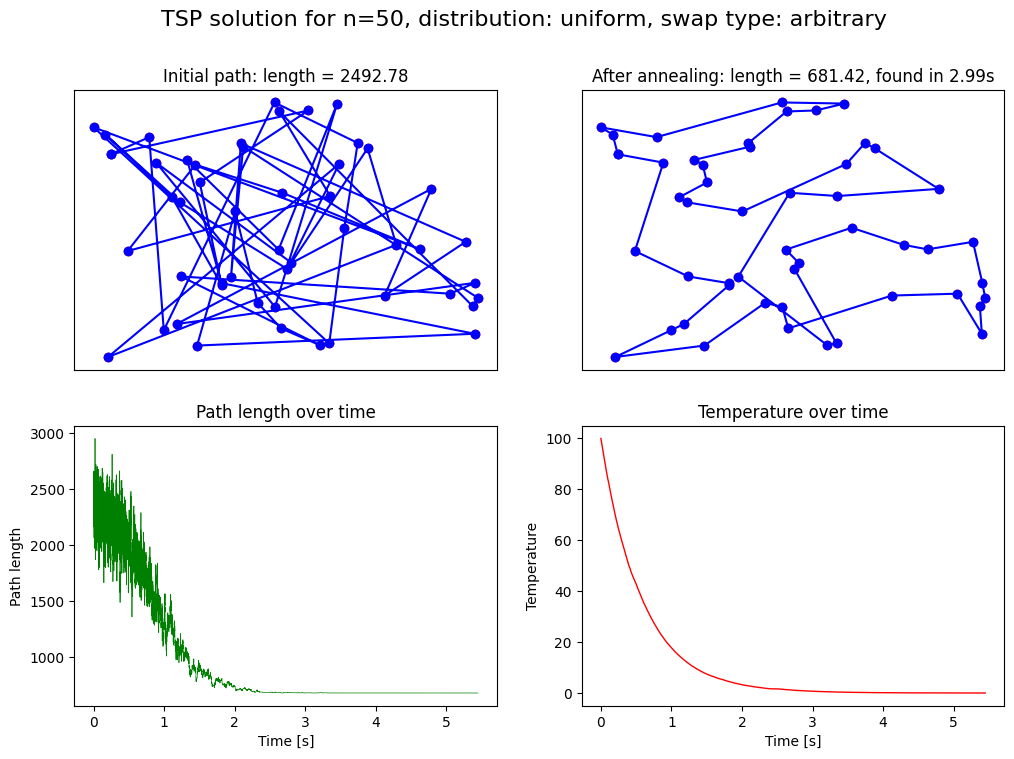

Distribution: uniform, swap type: consecutive
Initial path length: 2654.99
Best path length: 1485.27, found in 1.92s
Total elapsed time: 5.41s


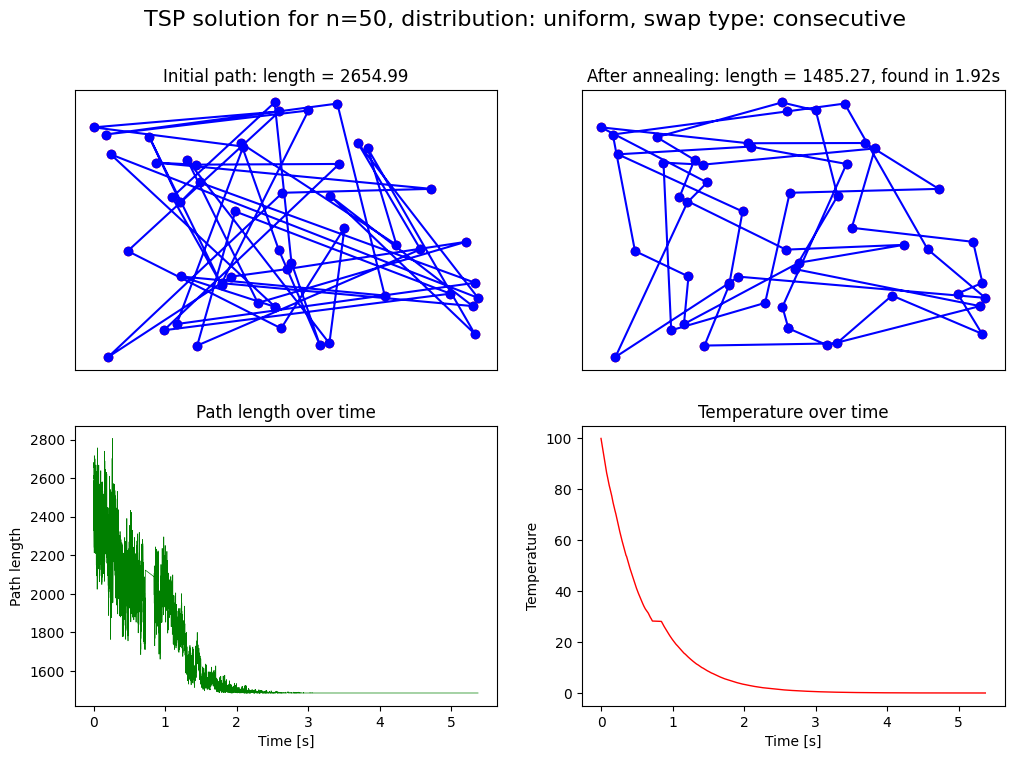

Shortest path comparison for different swap types:
arbitrary: 681.42
consecutive: 1485.27

--------------------

Distribution: normal, swap type: arbitrary
Initial path length: 2093.32
Best path length: 407.75, found in 4.39s
Total elapsed time: 5.65s


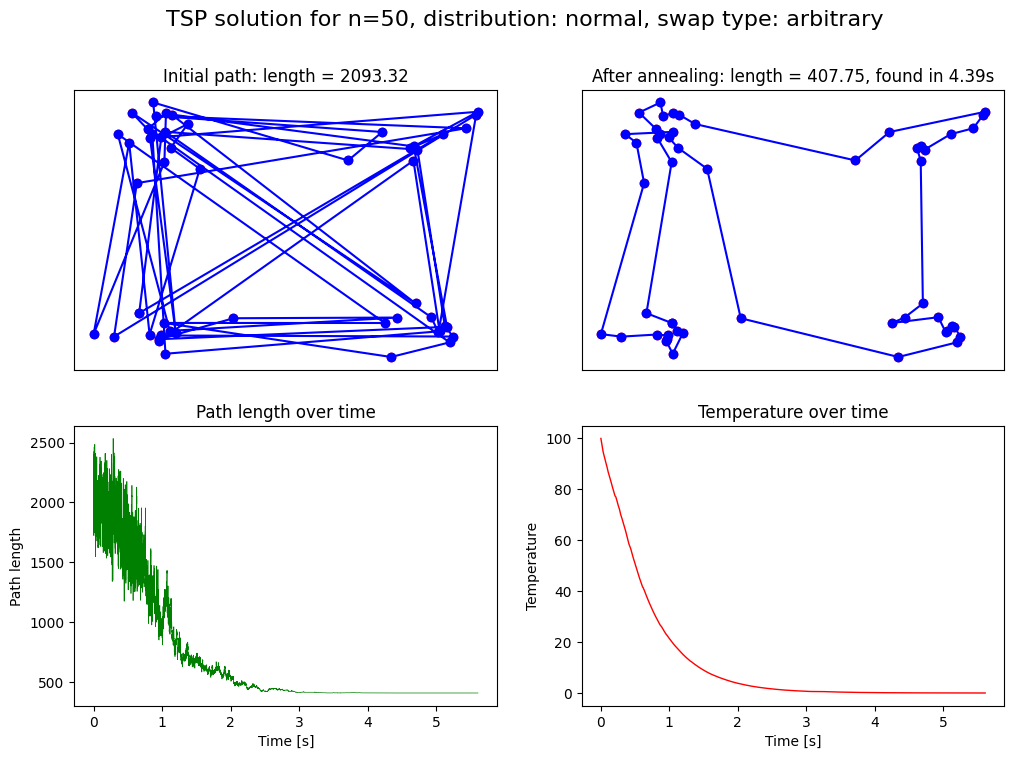

Distribution: normal, swap type: consecutive
Initial path length: 2444.15
Best path length: 836.88, found in 2.40s
Total elapsed time: 5.40s


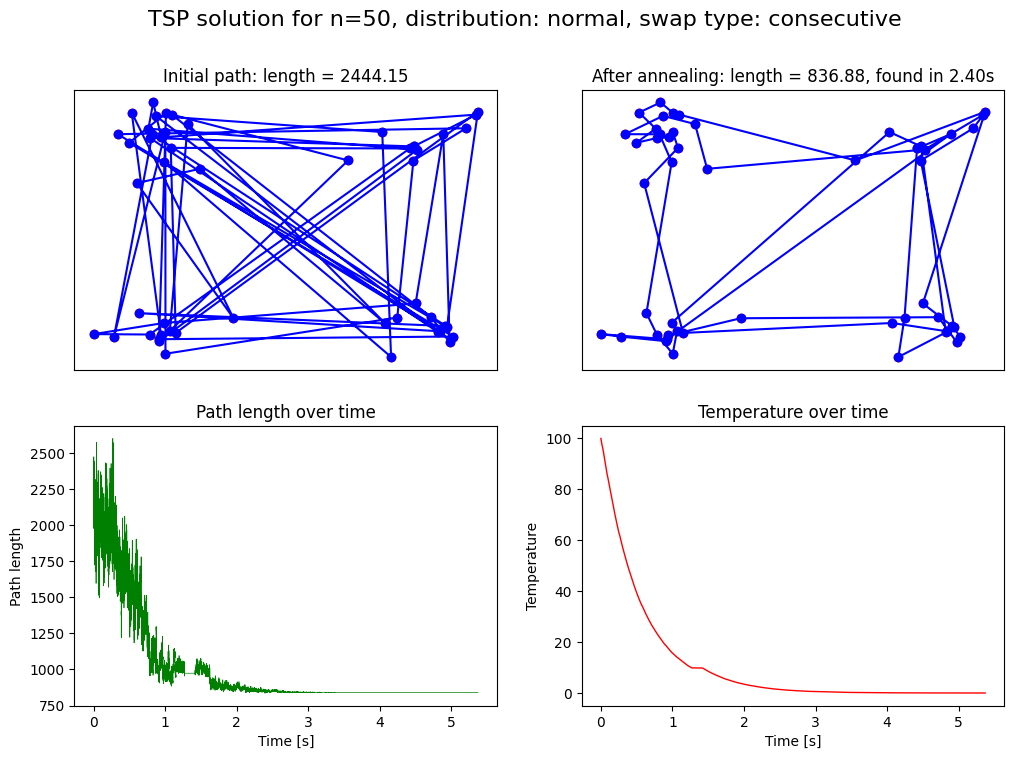

Shortest path comparison for different swap types:
arbitrary: 407.75
consecutive: 836.88

--------------------

Distribution: clusters, swap type: arbitrary
Initial path length: 2984.28
Best path length: 455.33, found in 4.18s
Total elapsed time: 5.64s


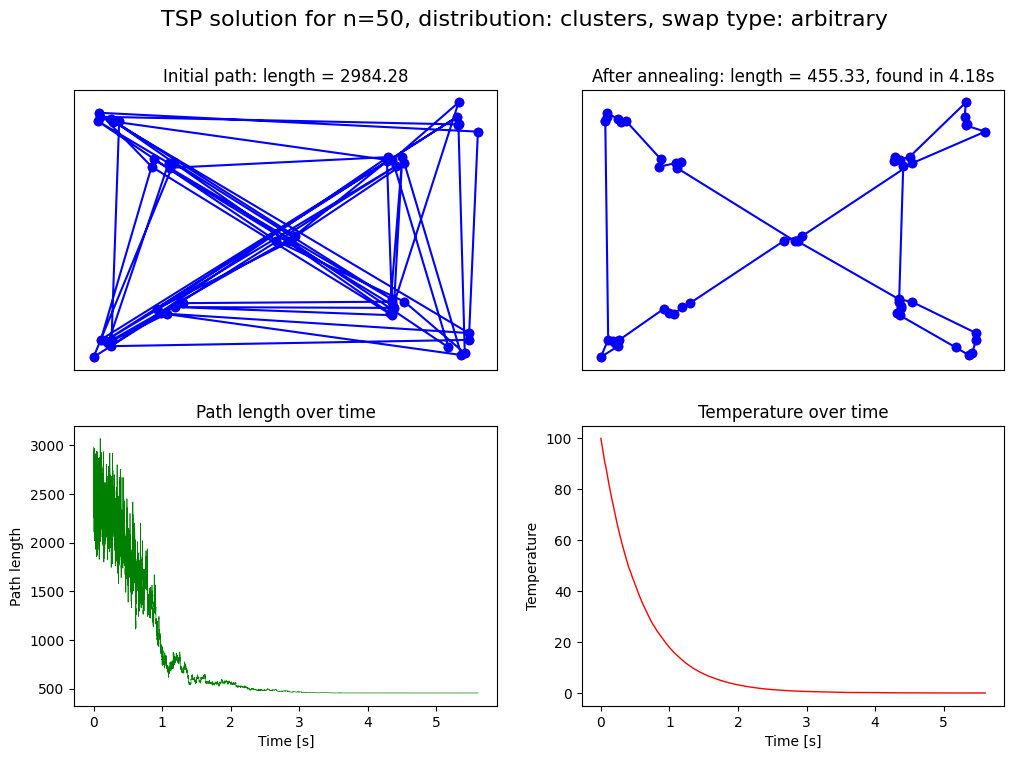

Distribution: clusters, swap type: consecutive
Initial path length: 2959.93
Best path length: 1441.47, found in 0.84s
Total elapsed time: 5.08s


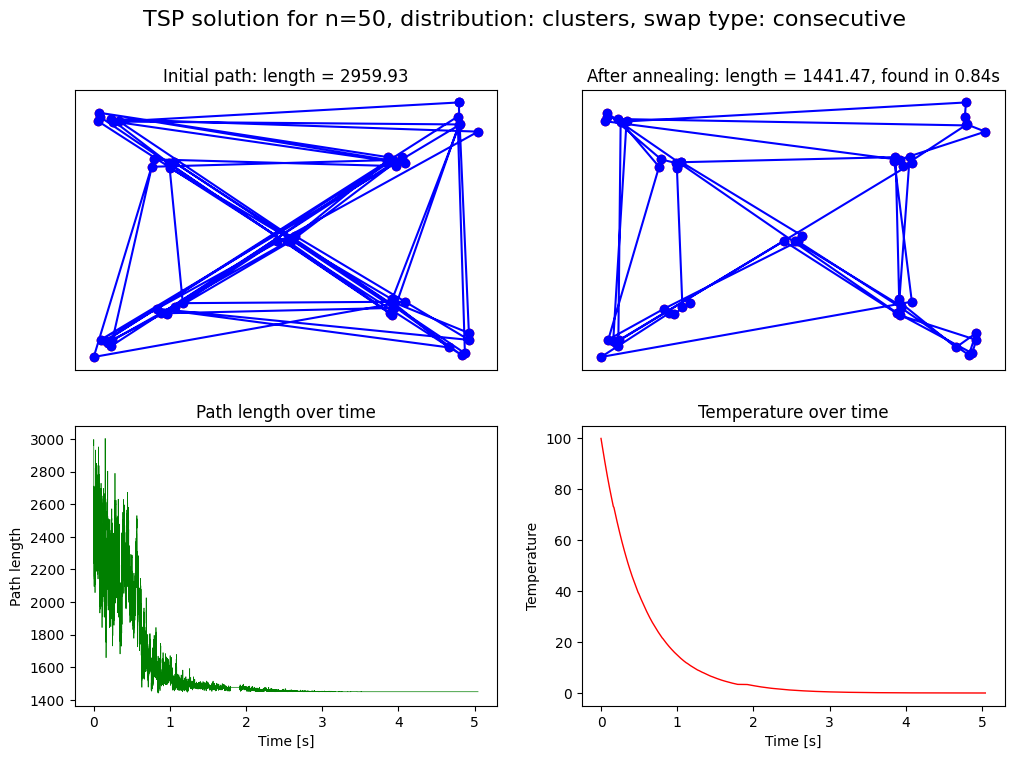

Shortest path comparison for different swap types:
arbitrary: 455.33
consecutive: 1441.47

---------- n = 100 ----------

Distribution: uniform, swap type: arbitrary
Initial path length: 5604.25
Best path length: 1158.17, found in 7.37s
Total elapsed time: 10.35s


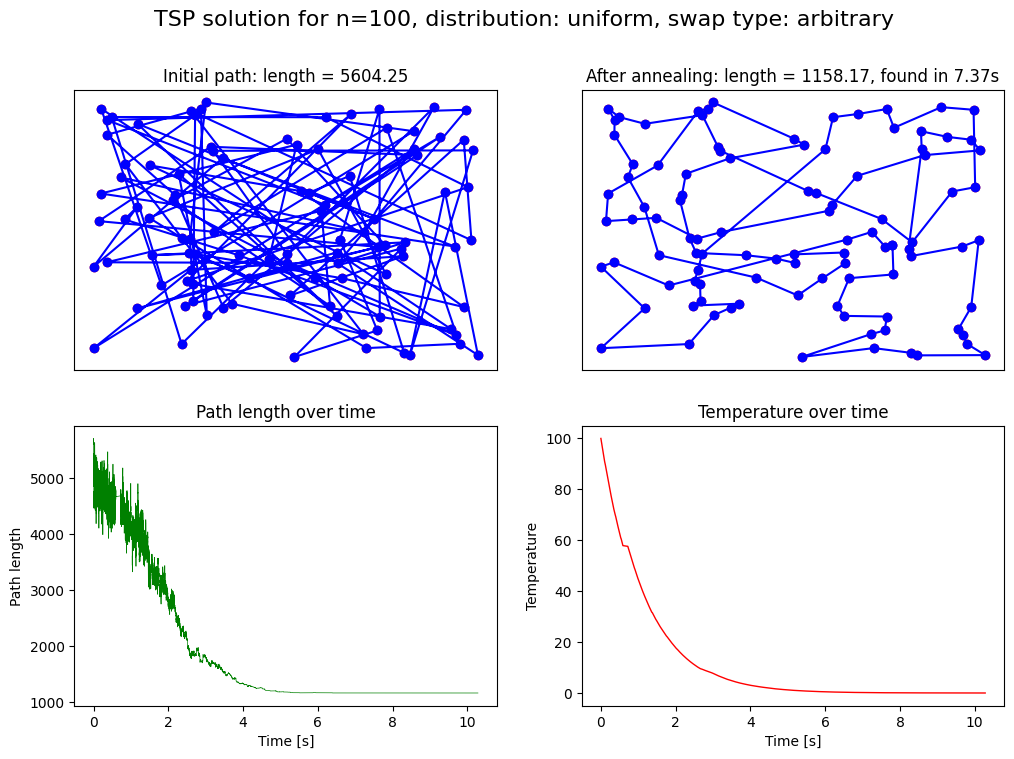

Distribution: uniform, swap type: consecutive
Initial path length: 5581.00
Best path length: 2703.40, found in 3.76s
Total elapsed time: 9.86s


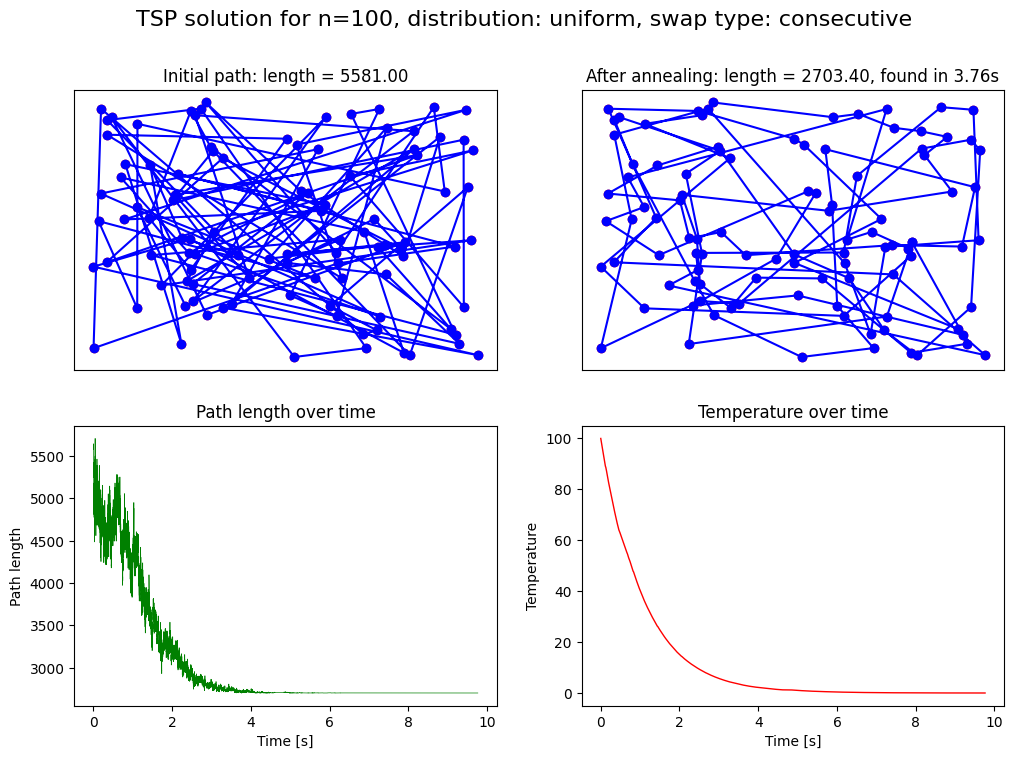

Shortest path comparison for different swap types:
arbitrary: 1158.17
consecutive: 2703.40

--------------------

Distribution: normal, swap type: arbitrary
Initial path length: 4511.75
Best path length: 721.54, found in 8.20s
Total elapsed time: 10.35s


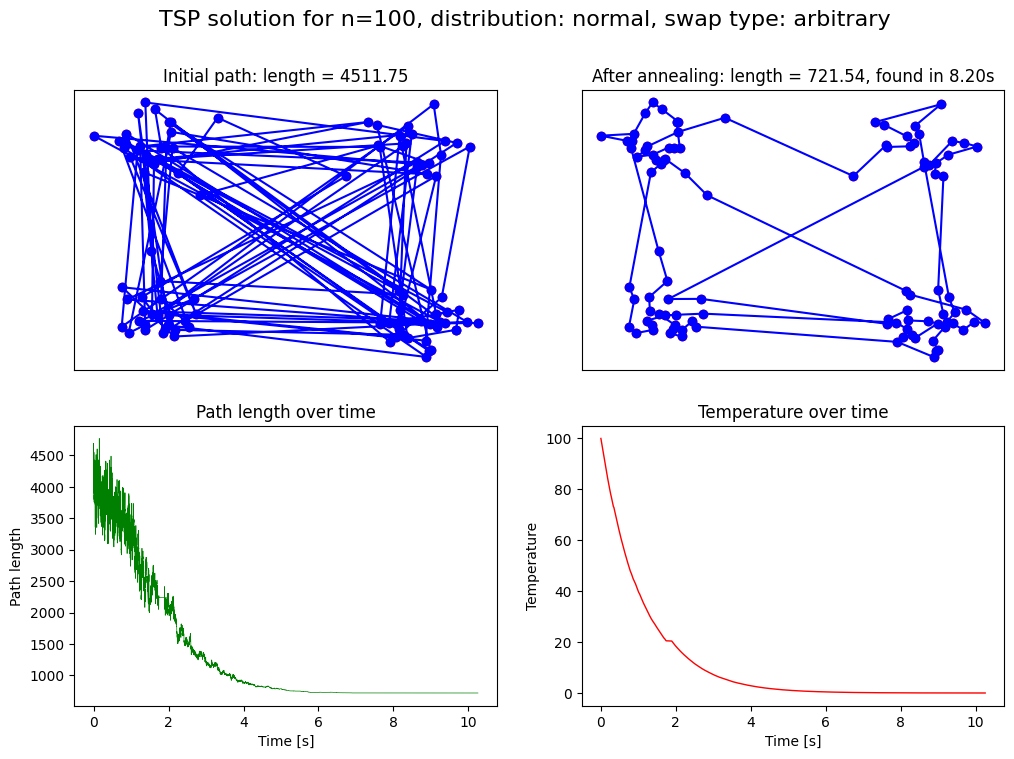

Distribution: normal, swap type: consecutive
Initial path length: 4717.58
Best path length: 2115.07, found in 4.91s
Total elapsed time: 9.92s


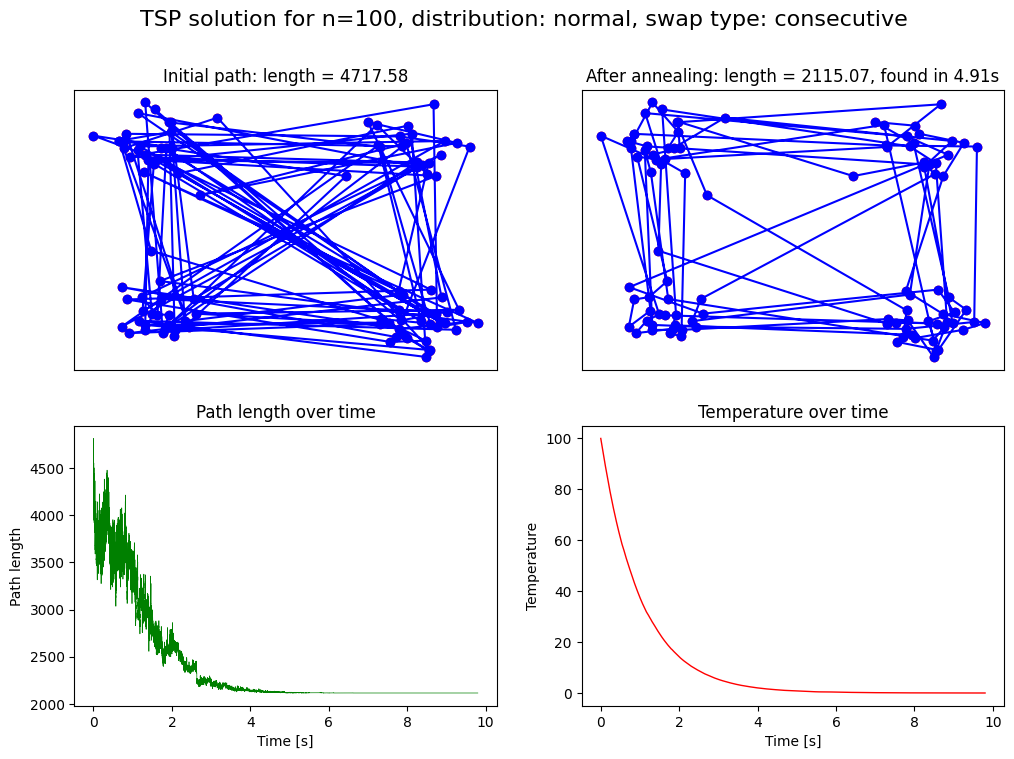

Shortest path comparison for different swap types:
arbitrary: 721.54
consecutive: 2115.07

--------------------

Distribution: clusters, swap type: arbitrary
Initial path length: 5918.75
Best path length: 642.92, found in 10.06s
Total elapsed time: 10.49s


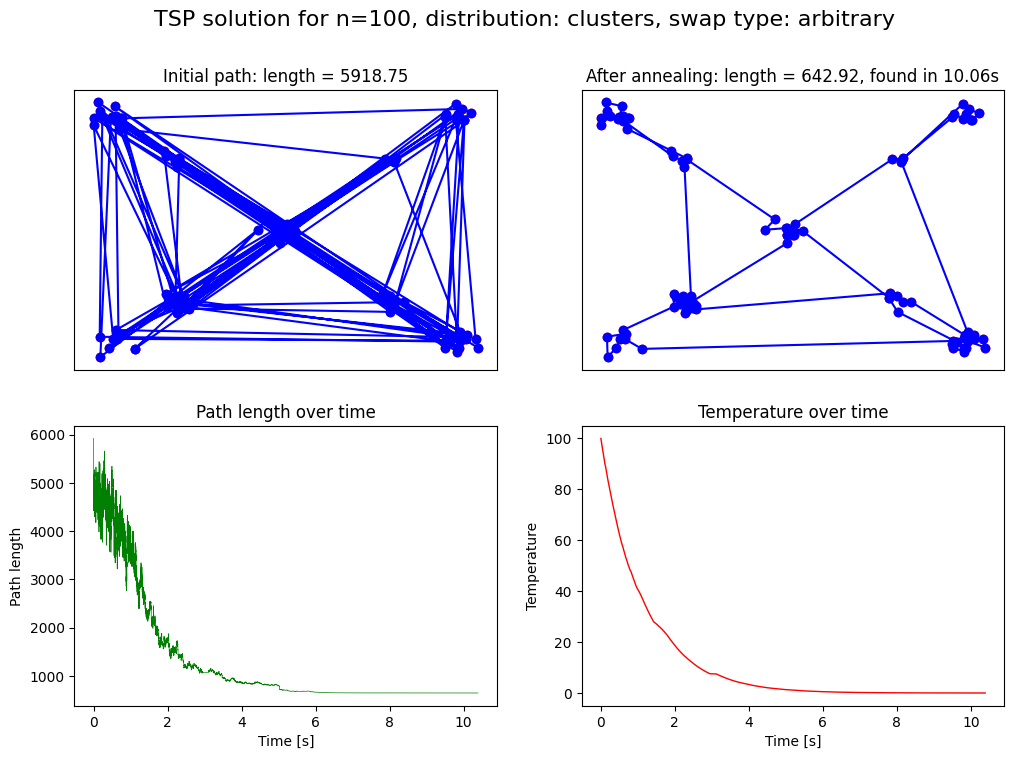

Distribution: clusters, swap type: consecutive
Initial path length: 5100.63
Best path length: 2495.79, found in 6.17s
Total elapsed time: 9.99s


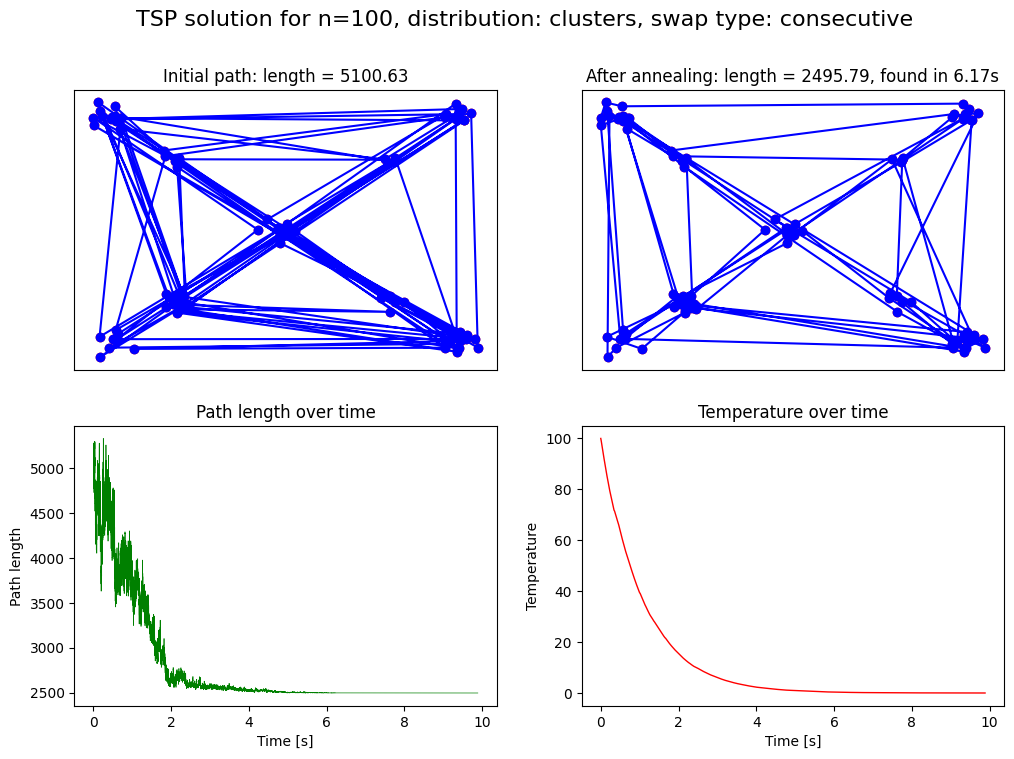

Shortest path comparison for different swap types:
arbitrary: 642.92
consecutive: 2495.79



In [8]:
n_values = [20, 50, 100]
distributions = ["uniform", "normal", "clusters"]
swap_types = ["arbitrary", "consecutive"]

for n in n_values:
    print(f"---------- n = {n} ----------\n")
    for dist in distributions:
        points = generate_points(n, dist)
        results = []
        for swap_type in swap_types:

            start = time.time()
            best_path, best_length, found_time, initial_path, initial_length, lengths, temps, paths =\
                simulated_annealing(points, swap_type=swap_type)
            elapsed = time.time() - start

            results.append((swap_type, best_length))

            print(f"Distribution: {dist}, swap type: {swap_type}")
            print(f"Initial path length: {initial_length:.2f}")
            print(f"Best path length: {best_length:.2f}, found in {found_time:.2f}s")
            print(f"Total elapsed time: {elapsed:.2f}s")

            plot_results(
                points,
                best_path,
                best_length,
                found_time,
                initial_path,
                initial_length,
                lengths,
                temps,
                n,
                dist,
                swap_type
            )

        print("Shortest path comparison for different swap types:") 
        for swap_type, best_length in results:
            print(f"{swap_type}: {best_length:.2f}")
        print()
        if dist != "clusters":
            print("--------------------\n")

#### Wnioski

Wyniki pokazują, że funkcja zmiany stanu `arbitrary`, mimo dłuższego czasu wykonywania, znajduje znacznie krótsze ścieżki niż `consecutive`.

Swobodniejsze zmiany stanu w funkcji `arbitrary` pozwalają lepiej eksplorować przestrzeń rozwiązań i minimalizują ryzyko "uwięzienia" w lokalnym minimum.

#### 4.2. Porównanie różnych funkcji zmiany temperatury

---------- n = 20 ----------

Distribution: uniform, temperature function: T = 0.999T
Initial path length: 827.19
Best path length: 337.59, found in 0.94s
Total elapsed time: 11.68s


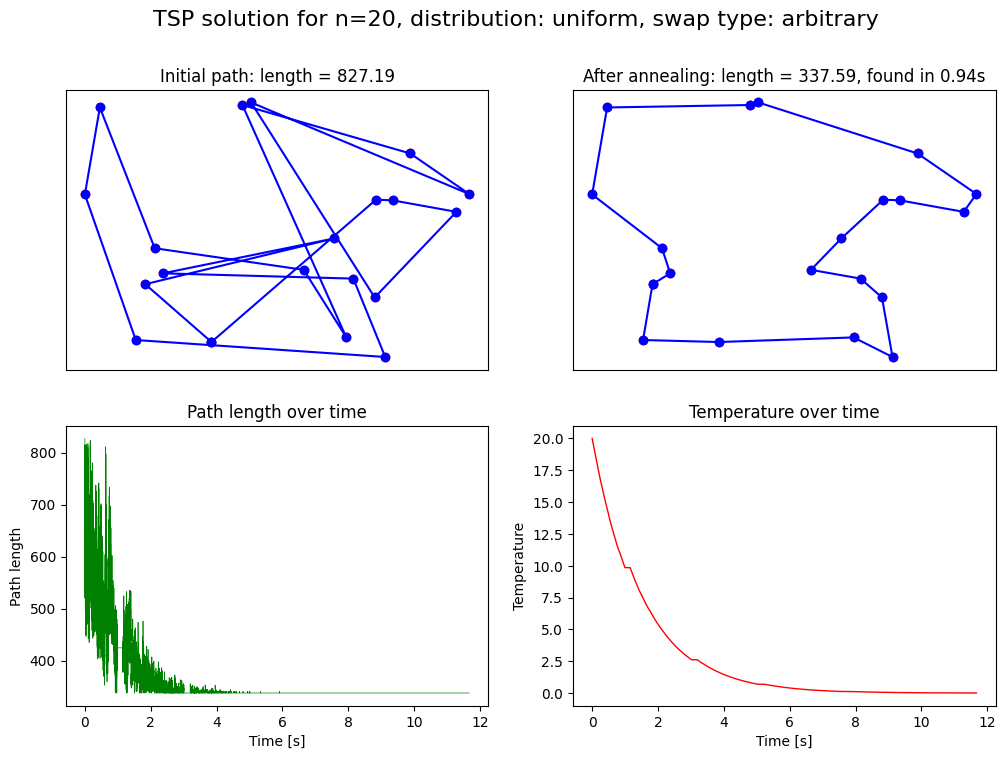

Distribution: uniform, temperature function: T = T_0(1 - t/12)
Initial path length: 934.55
Best path length: 337.59, found in 5.34s
Total elapsed time: 12.07s


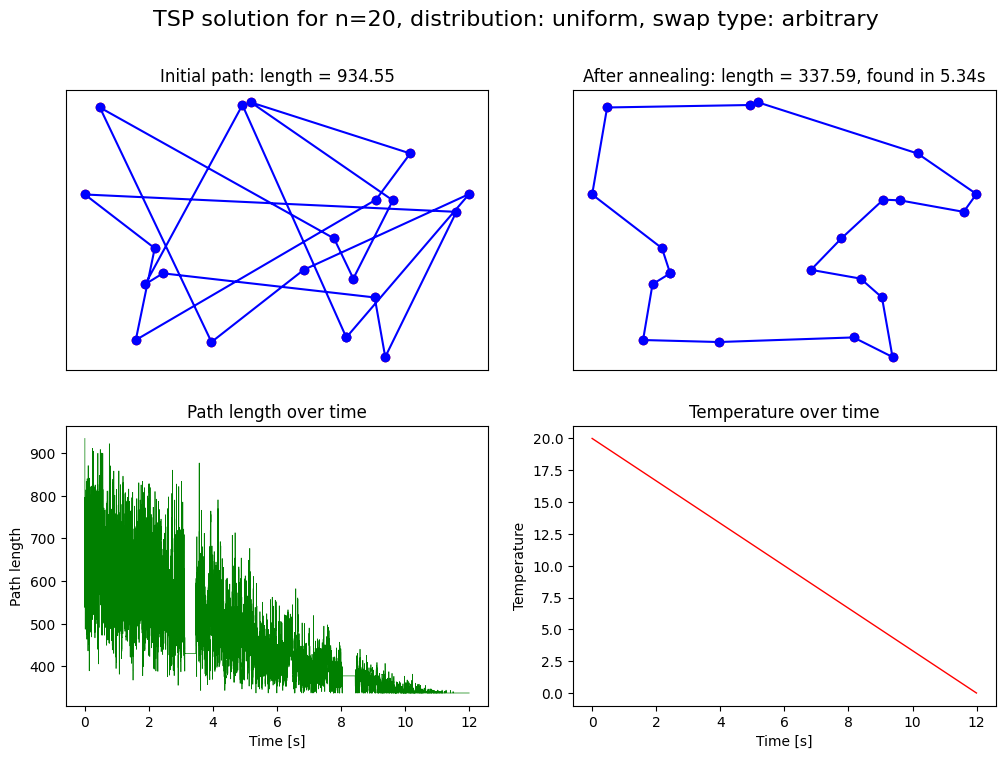

Distribution: uniform, temperature function: T = T_0cos(0.13t)
Initial path length: 1147.78
Best path length: 337.59, found in 7.90s
Total elapsed time: 12.17s


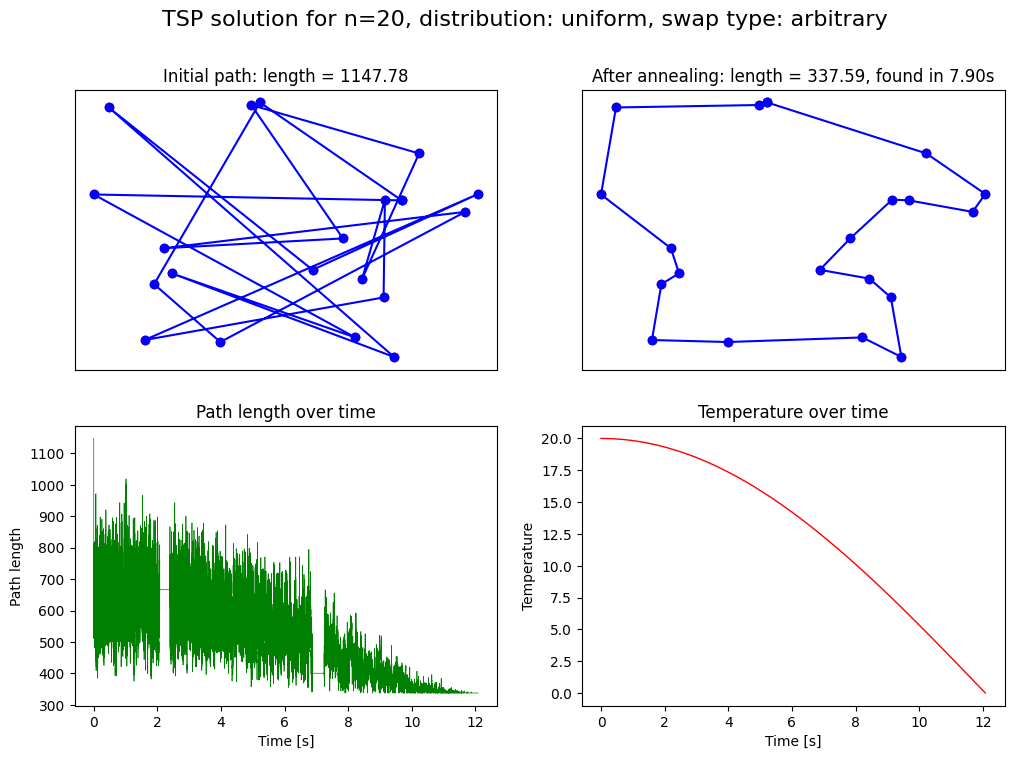

Shortest path comparison for different temperature functions:
T = 0.999T:        337.59, 0.94s
T = T_0(1 - t/12): 337.59, 5.34s
T = T_0cos(0.13t): 337.59, 7.90s

--------------------

Distribution: normal, temperature function: T = 0.999T
Initial path length: 740.83
Best path length: 259.03, found in 2.01s
Total elapsed time: 11.64s


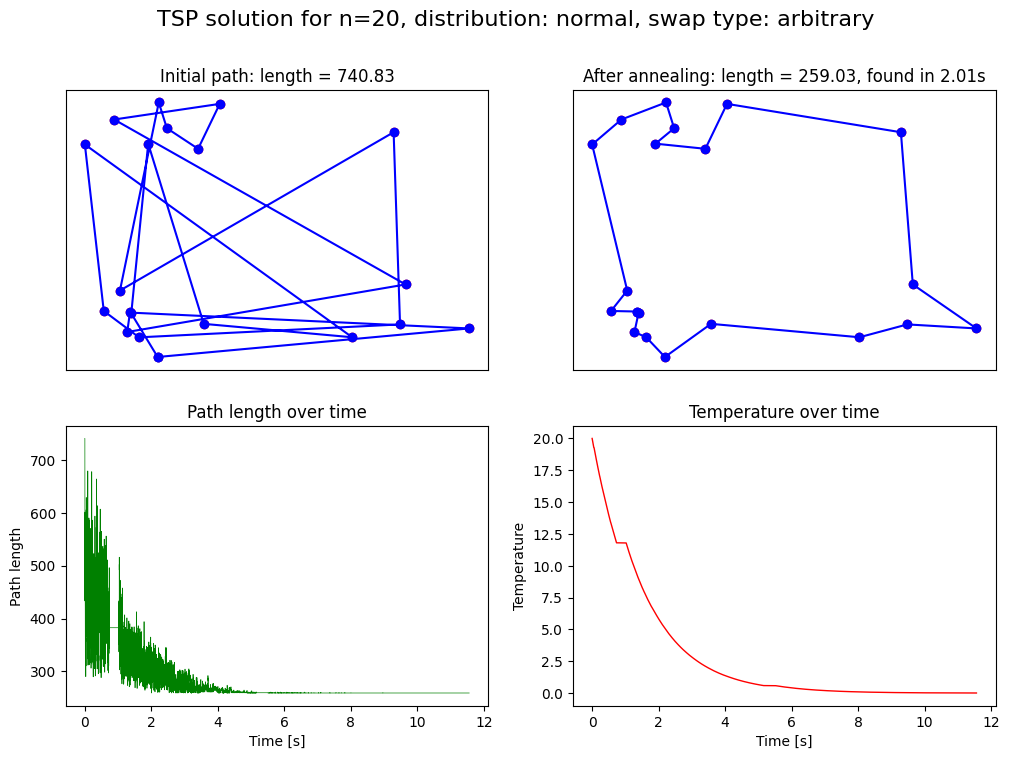

Distribution: normal, temperature function: T = T_0(1 - t/12)
Initial path length: 1016.63
Best path length: 259.03, found in 8.15s
Total elapsed time: 12.17s


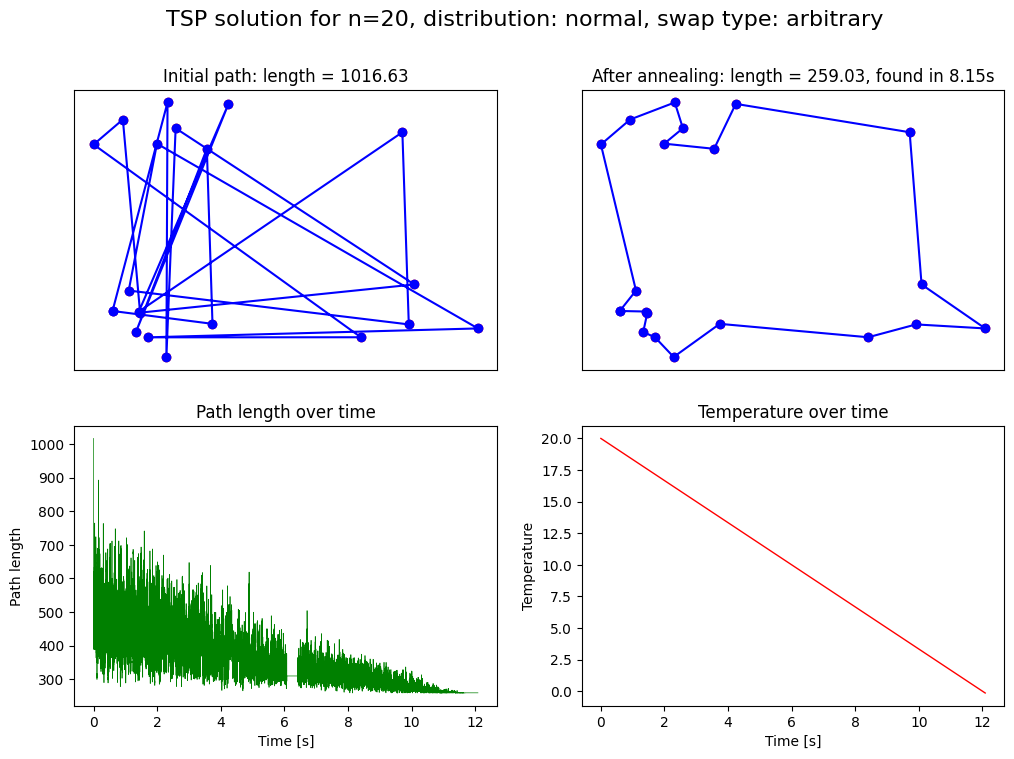

Distribution: normal, temperature function: T = T_0cos(0.13t)
Initial path length: 905.58
Best path length: 259.03, found in 10.18s
Total elapsed time: 12.17s


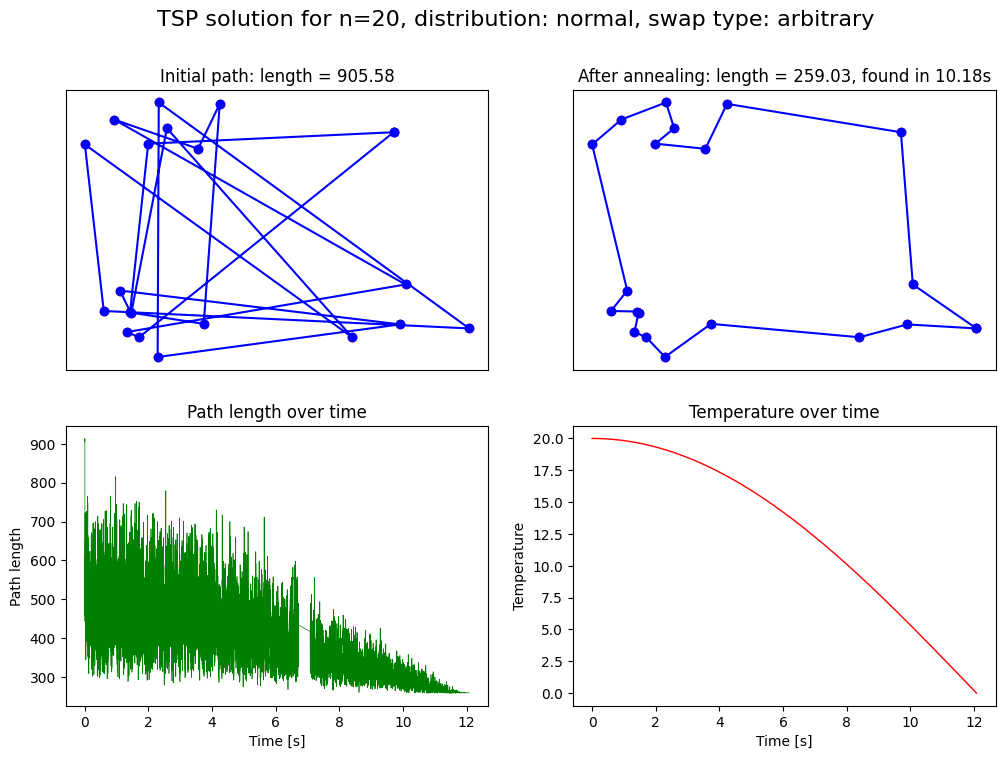

Shortest path comparison for different temperature functions:
T = 0.999T:        259.03, 2.01s
T = T_0(1 - t/12): 259.03, 8.15s
T = T_0cos(0.13t): 259.03, 10.18s

--------------------

Distribution: clusters, temperature function: T = 0.999T
Initial path length: 1034.96
Best path length: 385.94, found in 3.17s
Total elapsed time: 11.90s


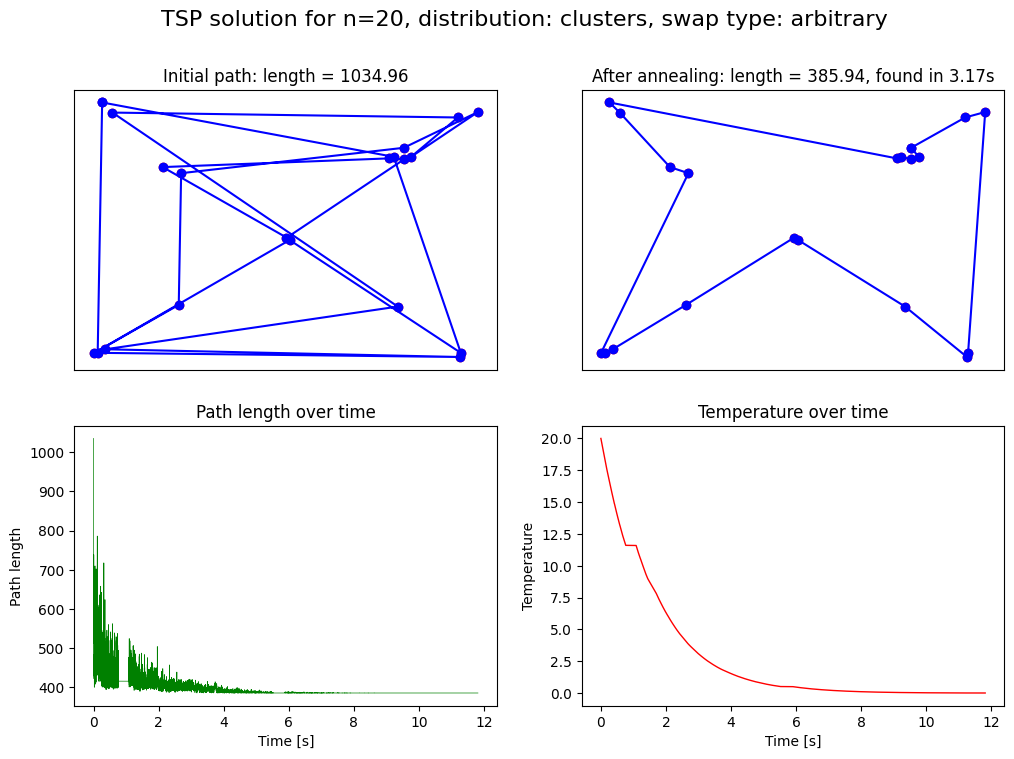

Distribution: clusters, temperature function: T = T_0(1 - t/12)
Initial path length: 976.57
Best path length: 385.94, found in 10.99s
Total elapsed time: 12.07s


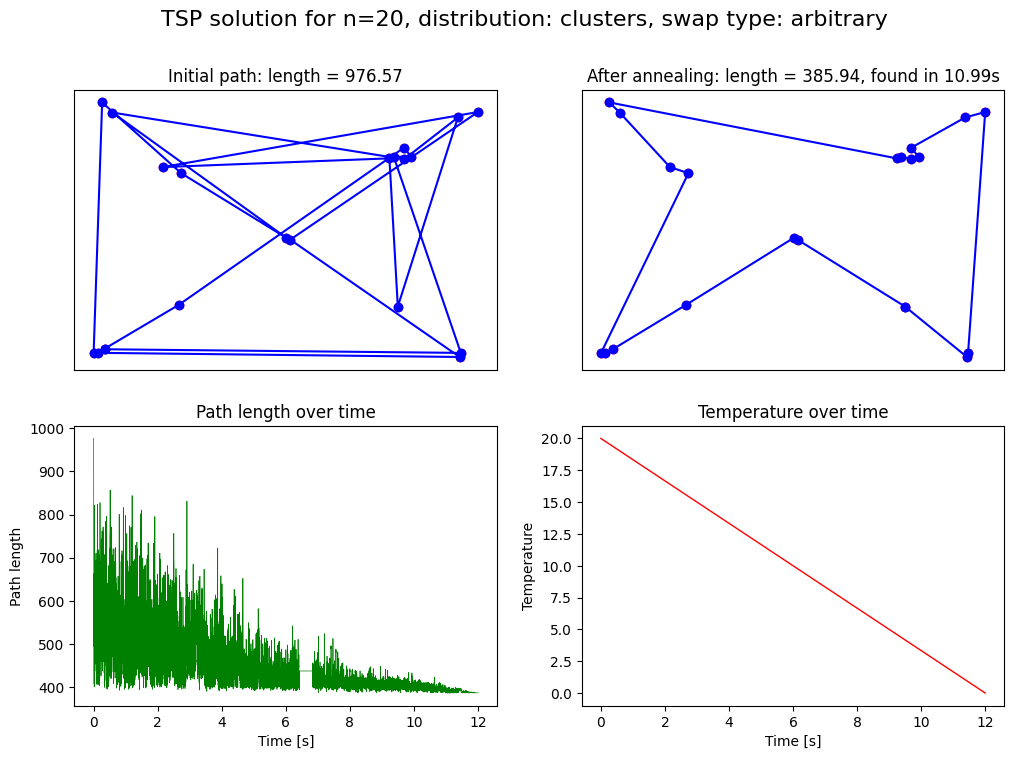

Distribution: clusters, temperature function: T = T_0cos(0.13t)
Initial path length: 1268.87
Best path length: 386.93, found in 8.68s
Total elapsed time: 12.17s


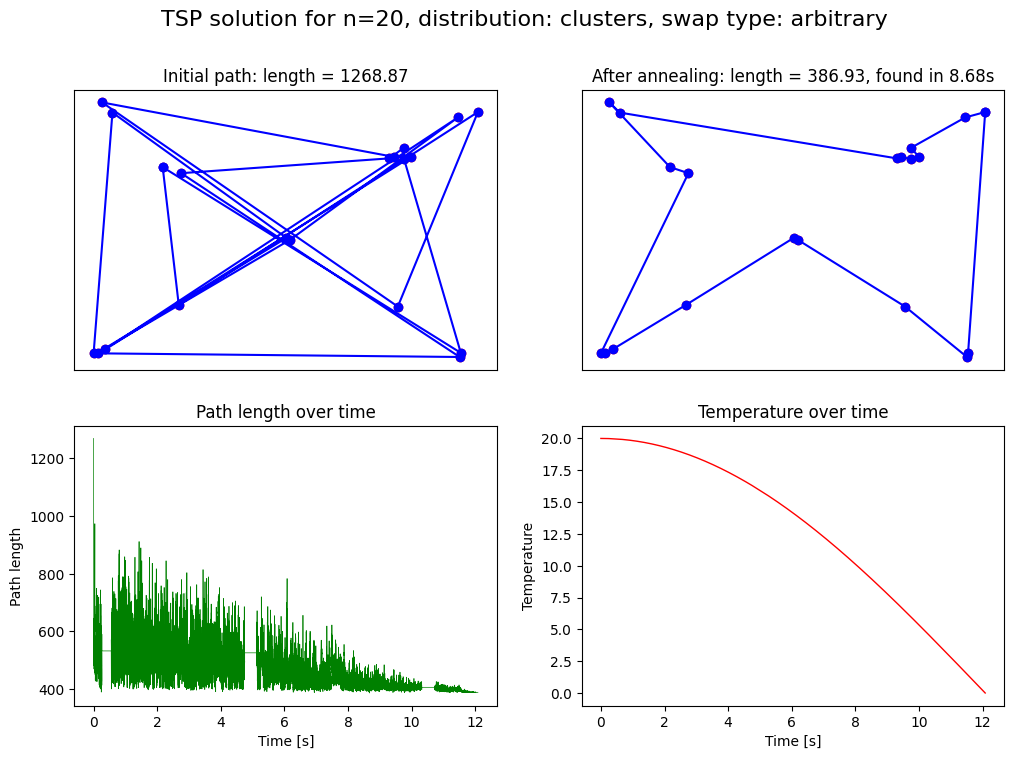

Shortest path comparison for different temperature functions:
T = 0.999T:        385.94, 3.17s
T = T_0(1 - t/12): 385.94, 10.99s
T = T_0cos(0.13t): 386.93, 8.68s

---------- n = 50 ----------

Distribution: uniform, temperature function: T = 0.999T
Initial path length: 3025.05
Best path length: 598.11, found in 8.61s
Total elapsed time: 22.86s


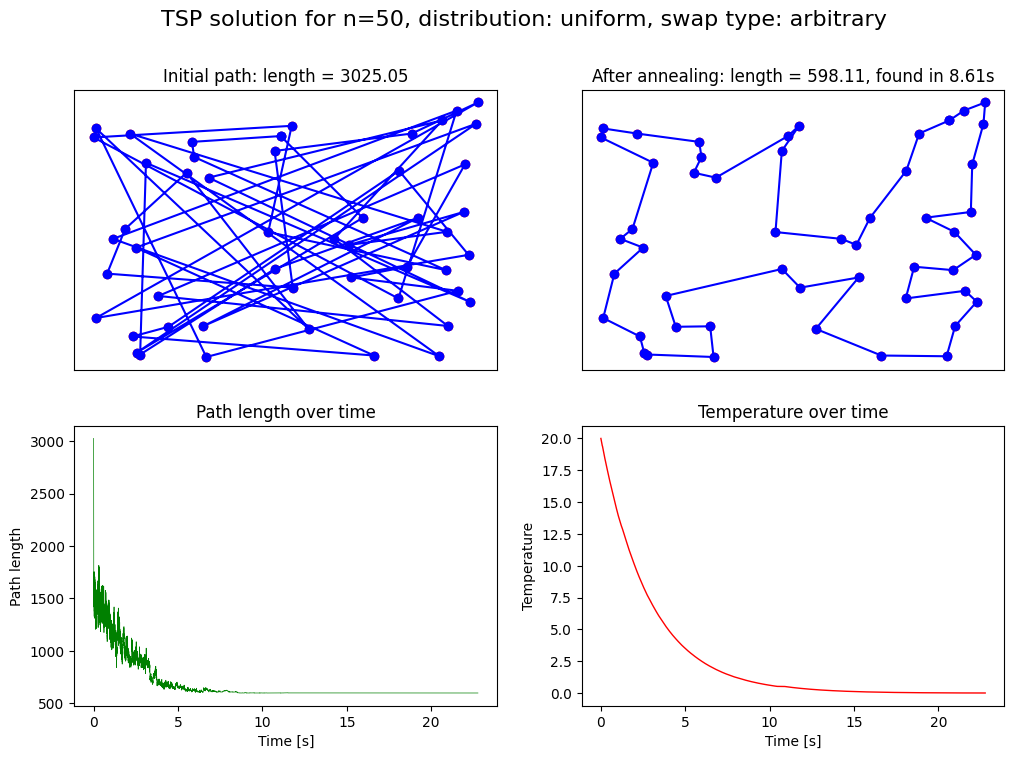

Distribution: uniform, temperature function: T = T_0(1 - t/12)
Initial path length: 2635.98
Best path length: 591.08, found in 10.66s
Total elapsed time: 12.11s


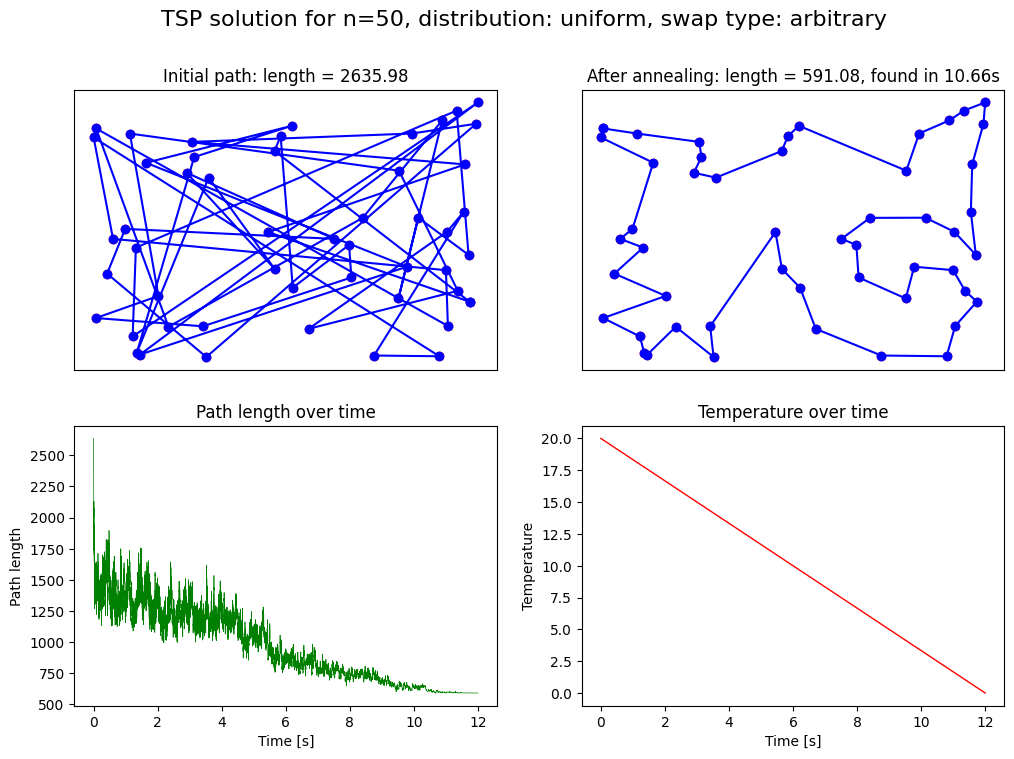

Distribution: uniform, temperature function: T = T_0cos(0.13t)
Initial path length: 2952.70
Best path length: 602.98, found in 11.57s
Total elapsed time: 12.15s


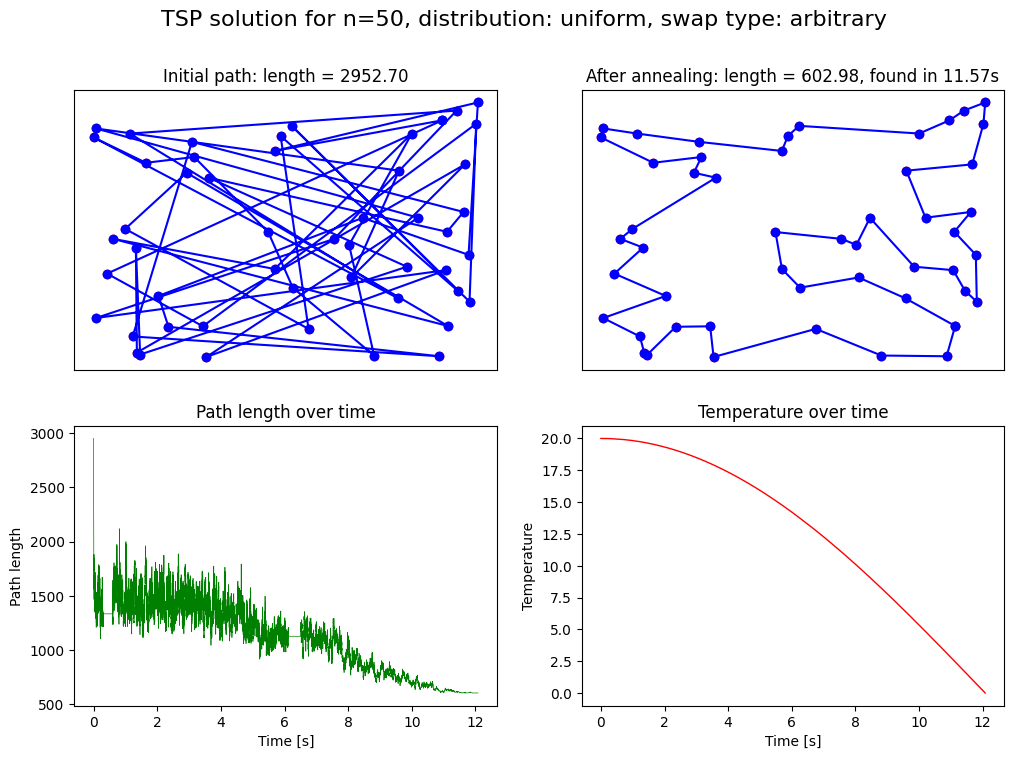

Shortest path comparison for different temperature functions:
T = 0.999T:        598.11, 8.61s
T = T_0(1 - t/12): 591.08, 10.66s
T = T_0cos(0.13t): 602.98, 11.57s

--------------------

Distribution: normal, temperature function: T = 0.999T
Initial path length: 1904.72
Best path length: 357.72, found in 10.00s
Total elapsed time: 23.21s


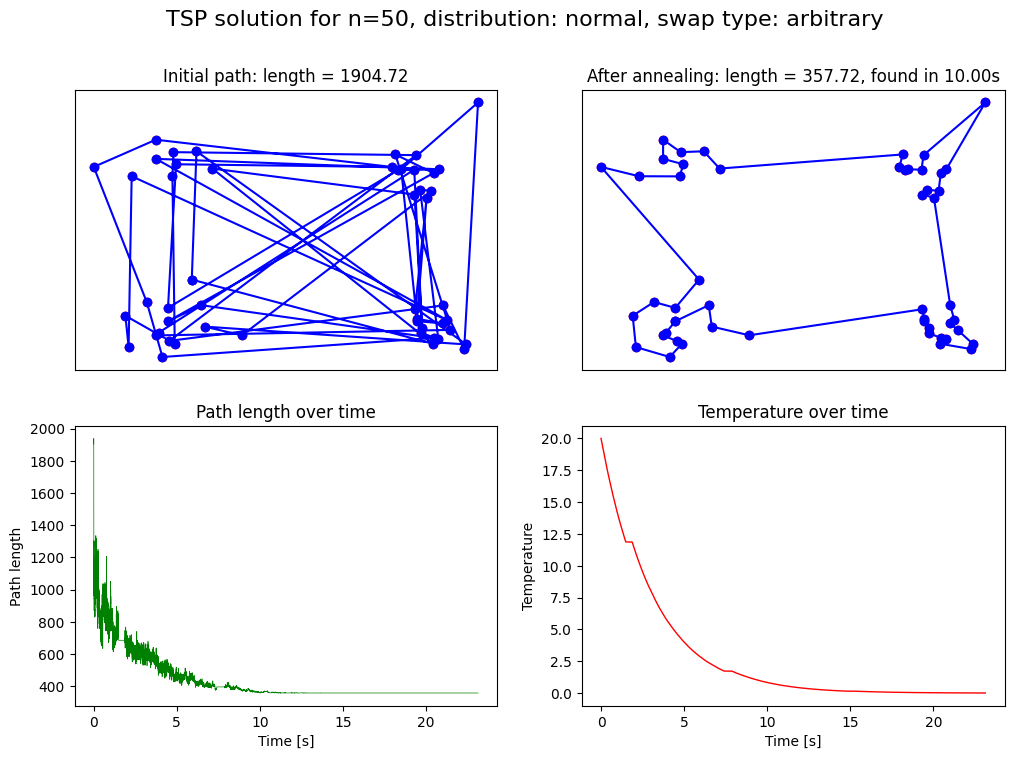

Distribution: normal, temperature function: T = T_0(1 - t/12)
Initial path length: 2160.62
Best path length: 367.11, found in 11.62s
Total elapsed time: 12.11s


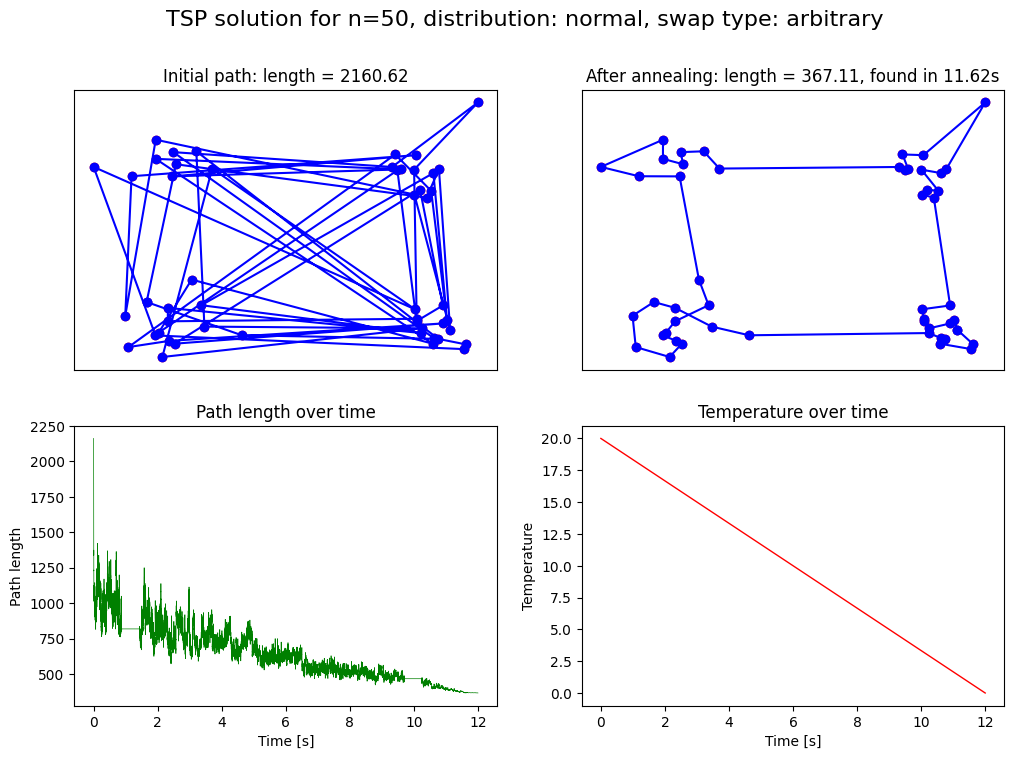

Distribution: normal, temperature function: T = T_0cos(0.13t)
Initial path length: 2313.58
Best path length: 449.37, found in 11.89s
Total elapsed time: 12.15s


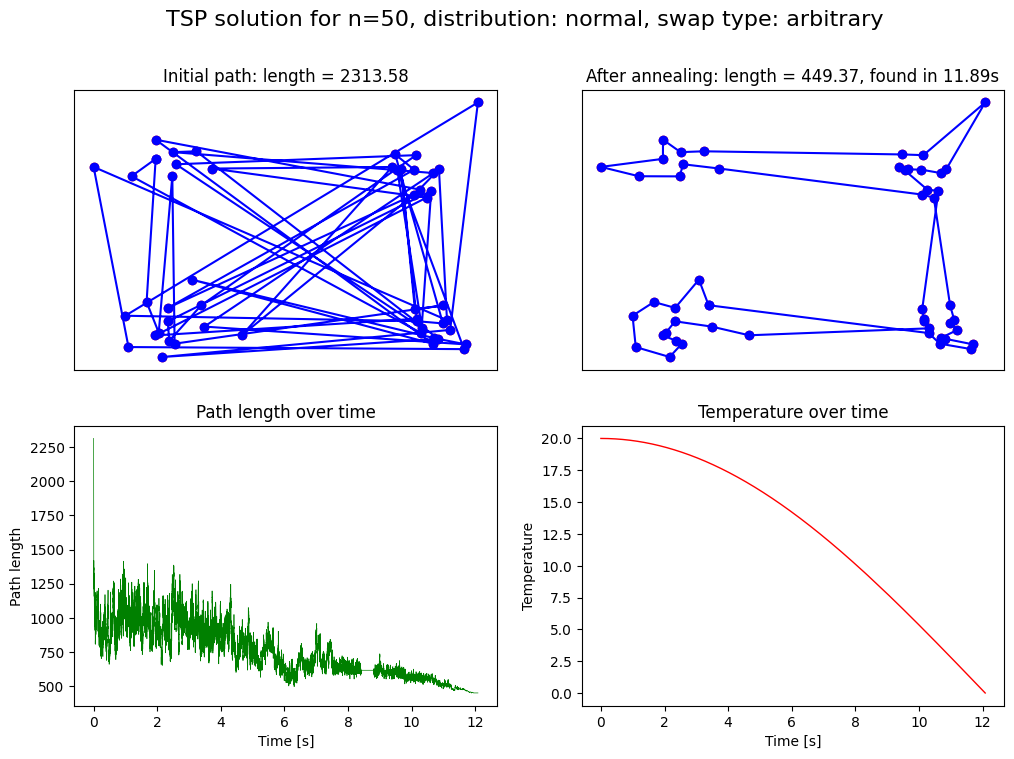

Shortest path comparison for different temperature functions:
T = 0.999T:        357.72, 10.00s
T = T_0(1 - t/12): 367.11, 11.62s
T = T_0cos(0.13t): 449.37, 11.89s

--------------------

Distribution: clusters, temperature function: T = 0.999T
Initial path length: 2742.86
Best path length: 413.86, found in 12.71s
Total elapsed time: 23.39s


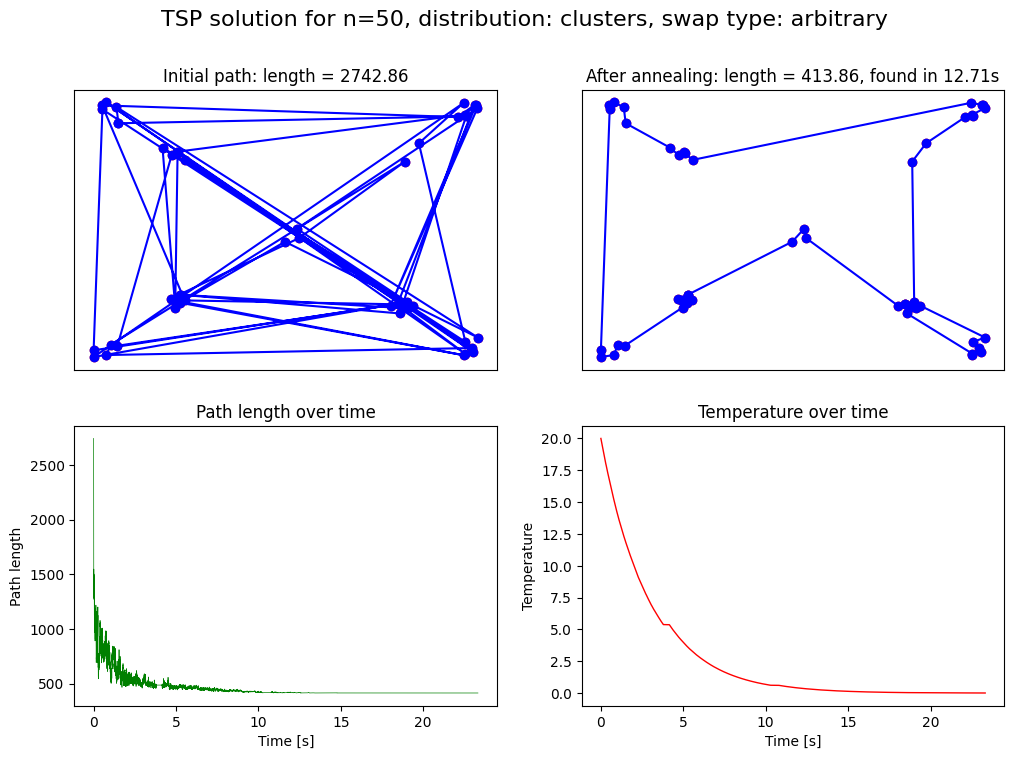

Distribution: clusters, temperature function: T = T_0(1 - t/12)
Initial path length: 2731.26
Best path length: 467.60, found in 11.97s
Total elapsed time: 12.11s


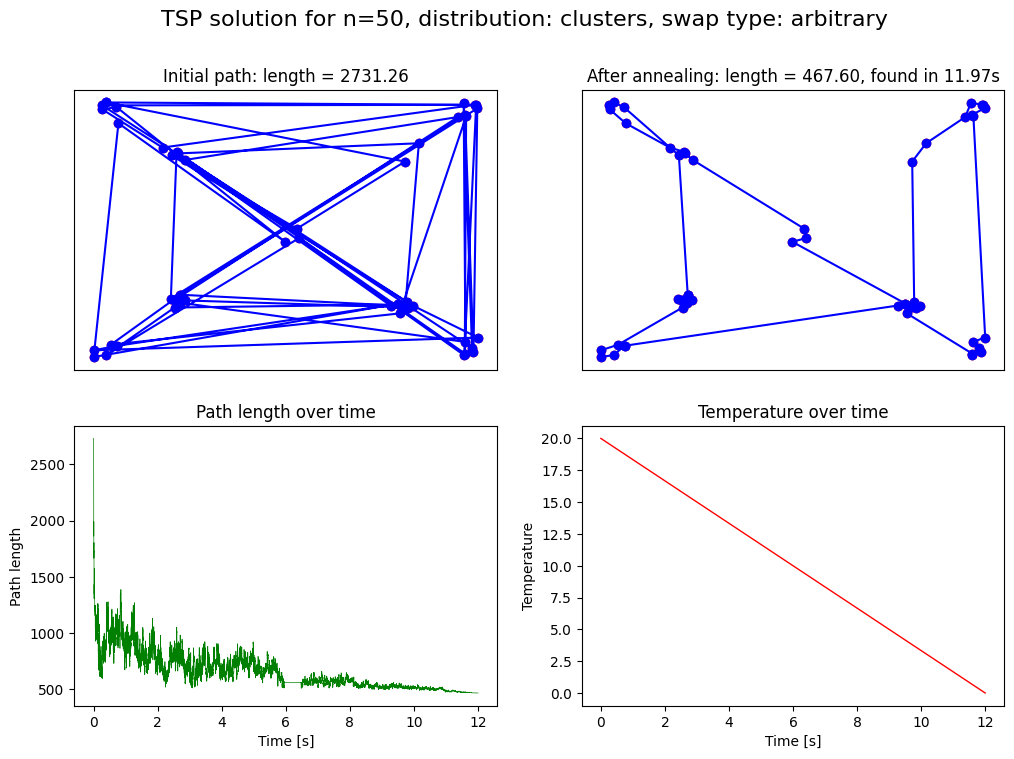

Distribution: clusters, temperature function: T = T_0cos(0.13t)
Initial path length: 2680.03
Best path length: 426.50, found in 12.06s
Total elapsed time: 12.14s


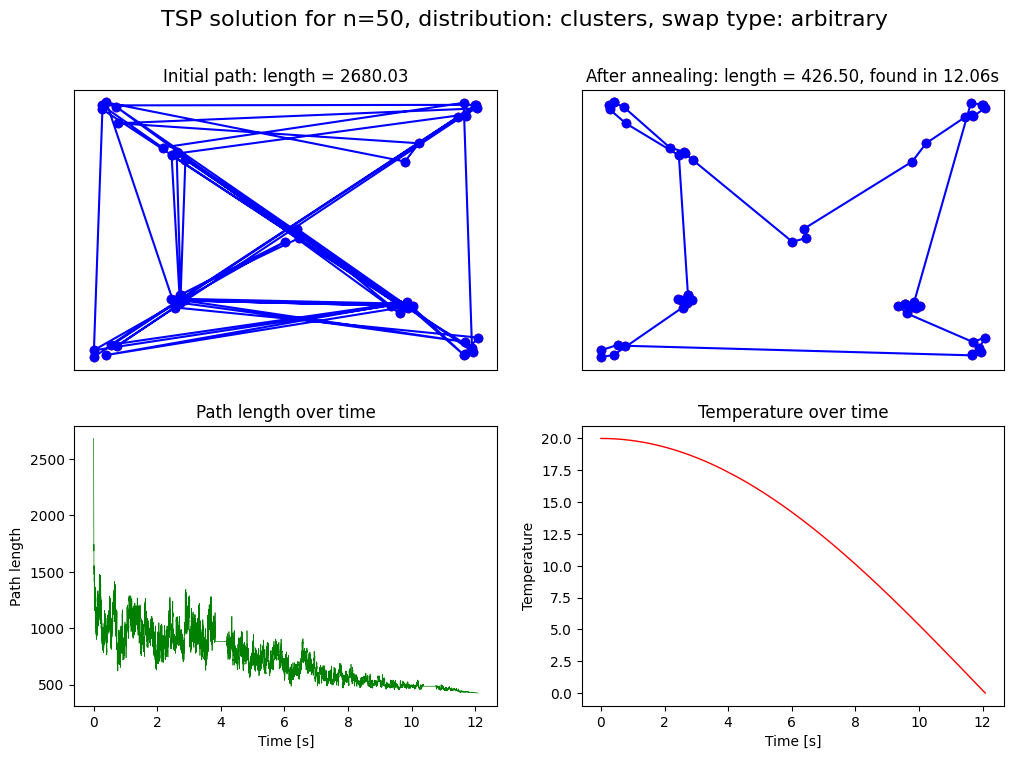

Shortest path comparison for different temperature functions:
T = 0.999T:        413.86, 12.71s
T = T_0(1 - t/12): 467.60, 11.97s
T = T_0cos(0.13t): 426.50, 12.06s

---------- n = 100 ----------

Distribution: uniform, temperature function: T = 0.999T
Initial path length: 5464.66
Best path length: 983.17, found in 20.00s
Total elapsed time: 42.09s


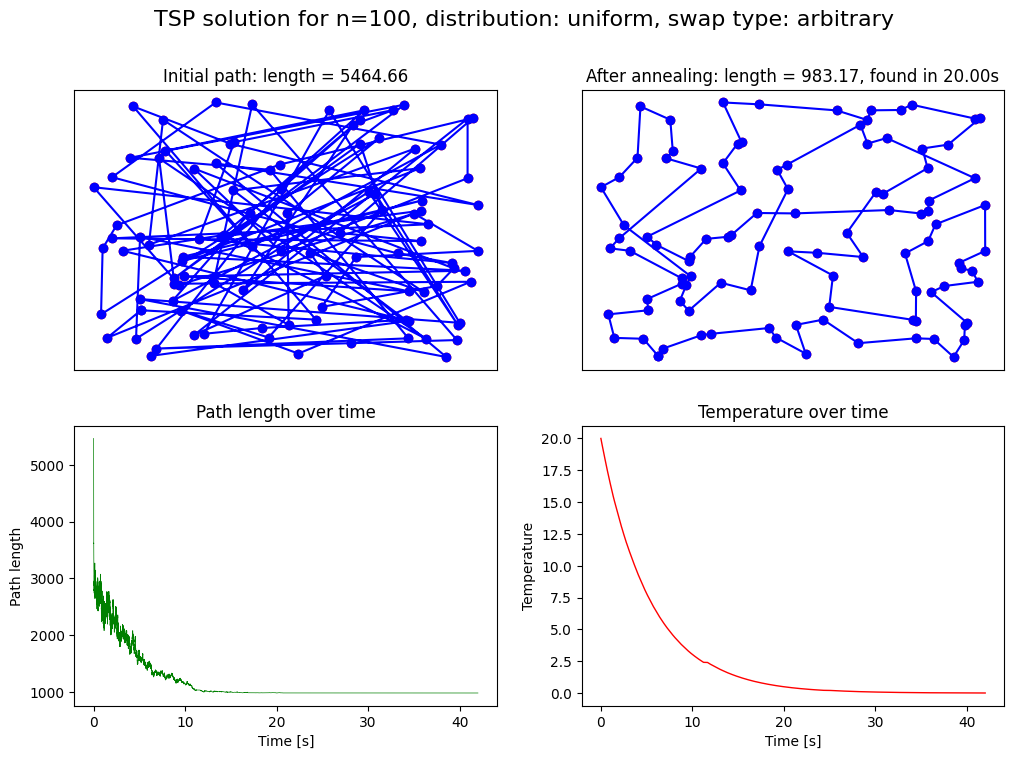

Distribution: uniform, temperature function: T = T_0(1 - t/12)
Initial path length: 5035.64
Best path length: 1036.64, found in 11.97s
Total elapsed time: 12.27s


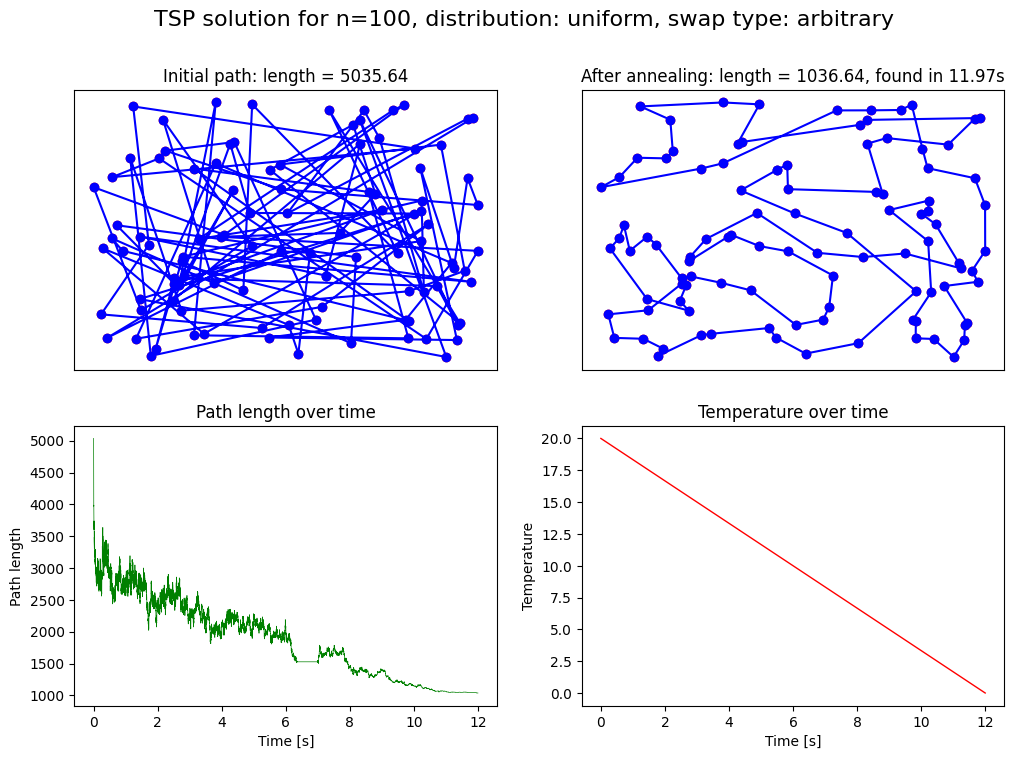

Distribution: uniform, temperature function: T = T_0cos(0.13t)
Initial path length: 5509.18
Best path length: 1073.70, found in 12.07s
Total elapsed time: 12.21s


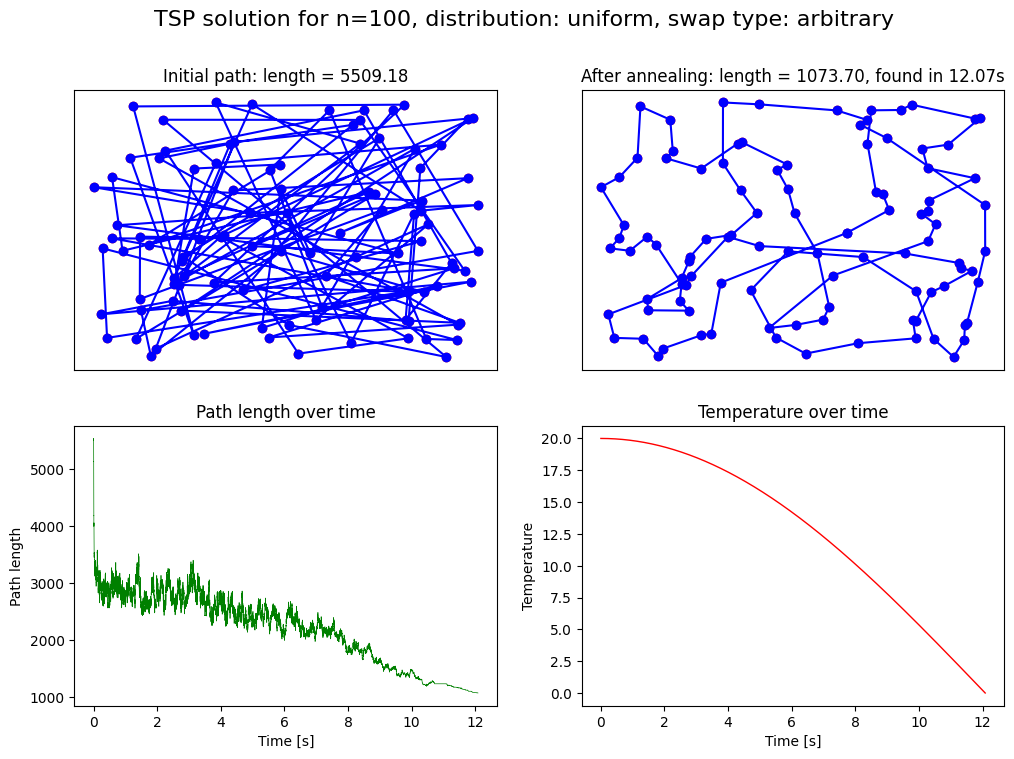

Shortest path comparison for different temperature functions:
T = 0.999T:        983.17, 20.00s
T = T_0(1 - t/12): 1036.64, 11.97s
T = T_0cos(0.13t): 1073.70, 12.07s

--------------------

Distribution: normal, temperature function: T = 0.999T
Initial path length: 4848.24
Best path length: 696.78, found in 30.38s
Total elapsed time: 45.75s


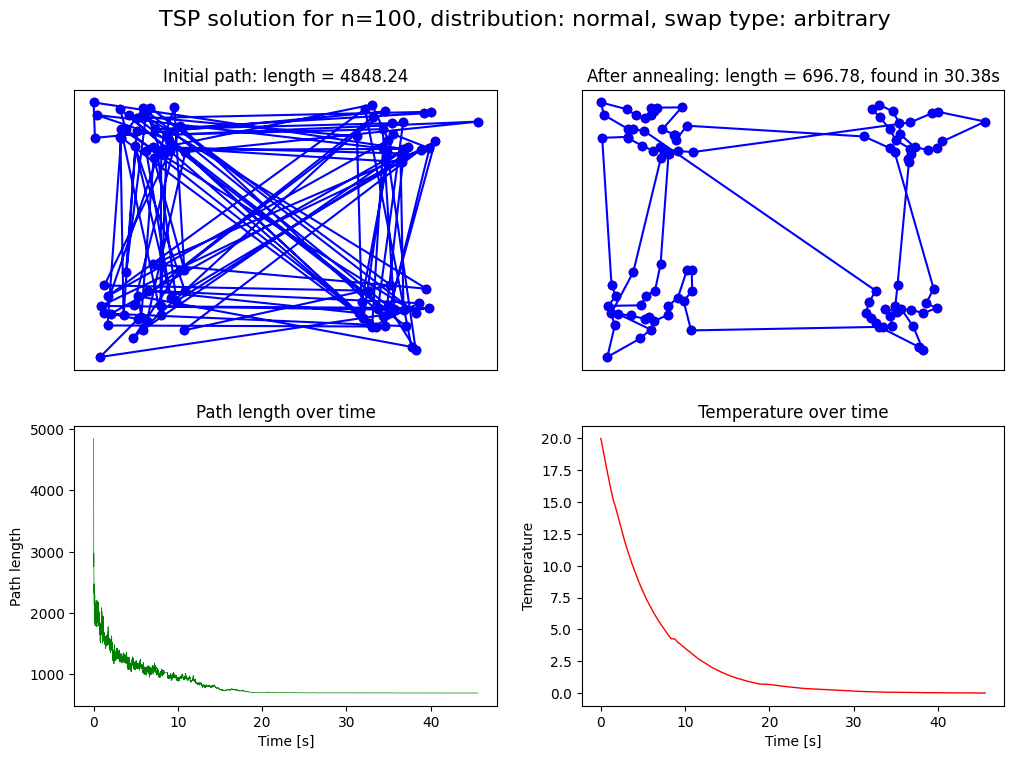

Distribution: normal, temperature function: T = T_0(1 - t/12)
Initial path length: 4441.59
Best path length: 705.31, found in 11.97s
Total elapsed time: 12.27s


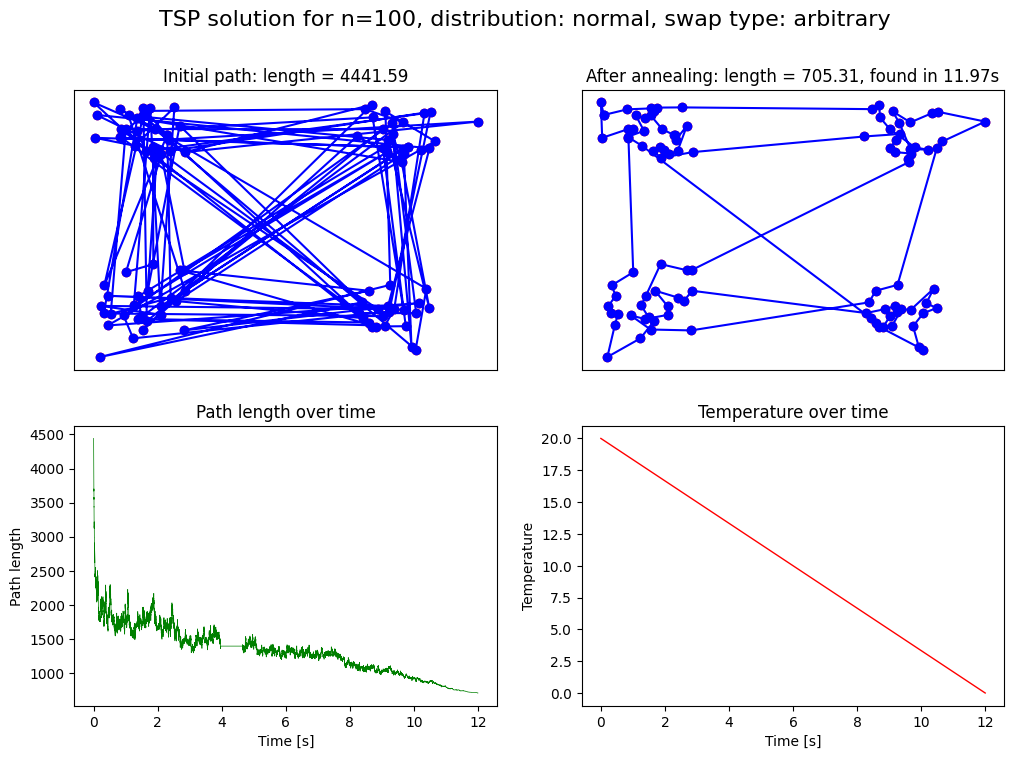

Distribution: normal, temperature function: T = T_0cos(0.13t)
Initial path length: 4436.16
Best path length: 672.01, found in 12.07s
Total elapsed time: 12.18s


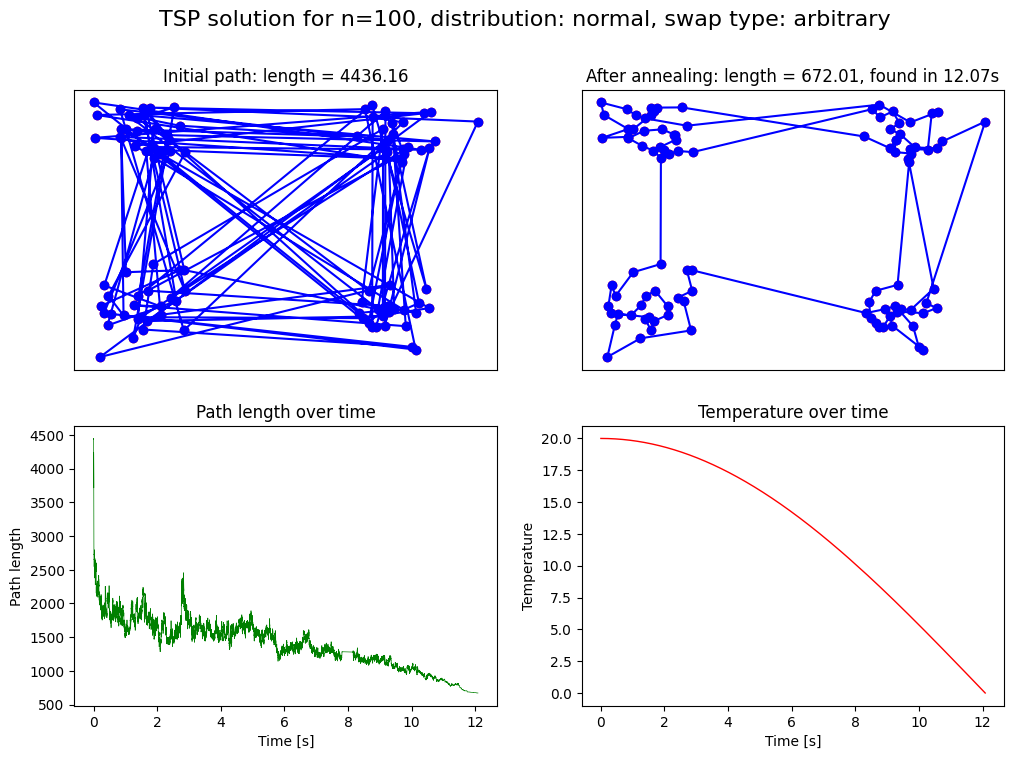

Shortest path comparison for different temperature functions:
T = 0.999T:        696.78, 30.38s
T = T_0(1 - t/12): 705.31, 11.97s
T = T_0cos(0.13t): 672.01, 12.07s

--------------------

Distribution: clusters, temperature function: T = 0.999T
Initial path length: 5229.53
Best path length: 591.44, found in 28.85s
Total elapsed time: 43.19s


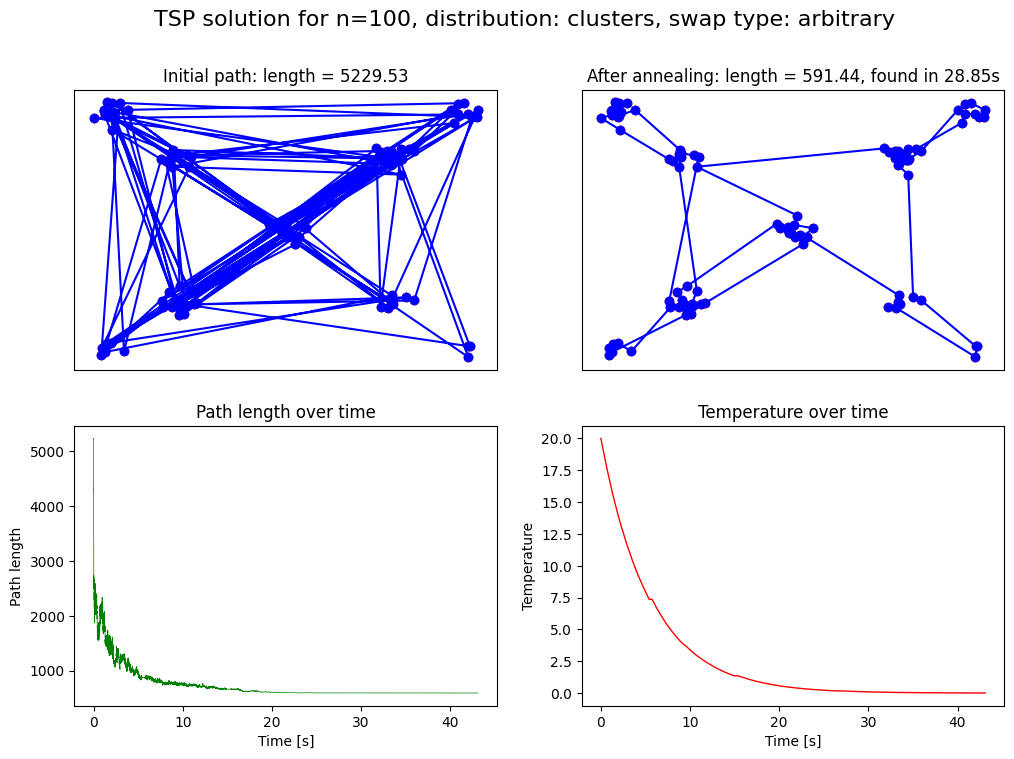

Distribution: clusters, temperature function: T = T_0(1 - t/12)
Initial path length: 4750.18
Best path length: 567.74, found in 11.99s
Total elapsed time: 12.26s


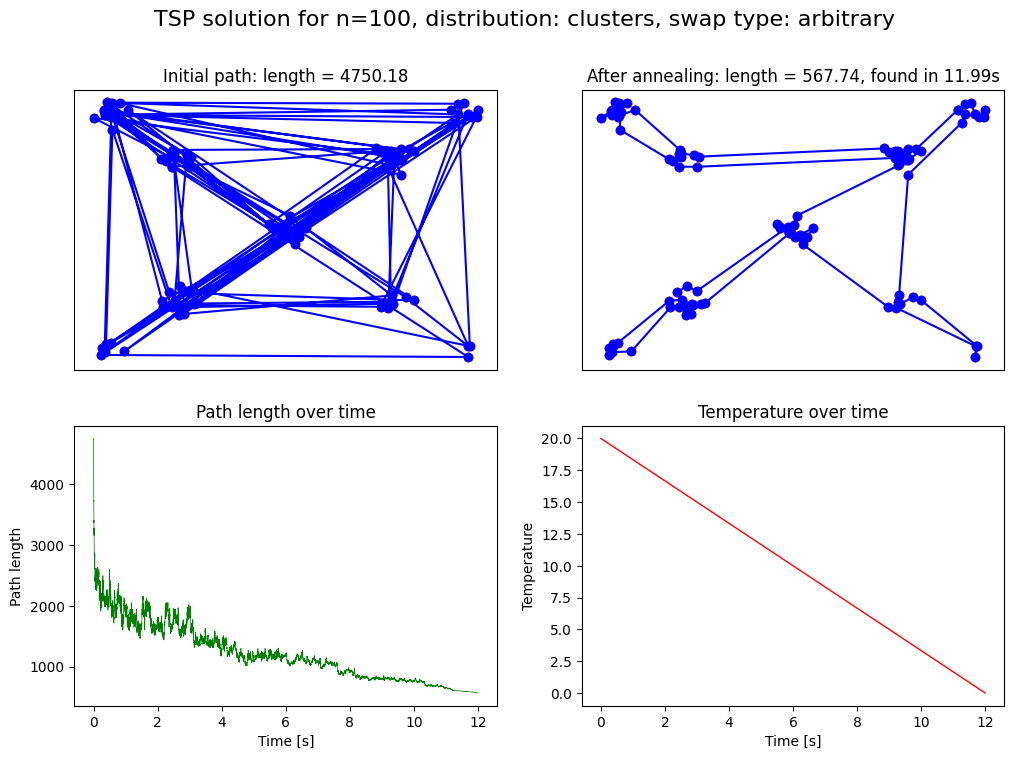

Distribution: clusters, temperature function: T = T_0cos(0.13t)
Initial path length: 4927.55
Best path length: 705.23, found in 12.07s
Total elapsed time: 12.18s


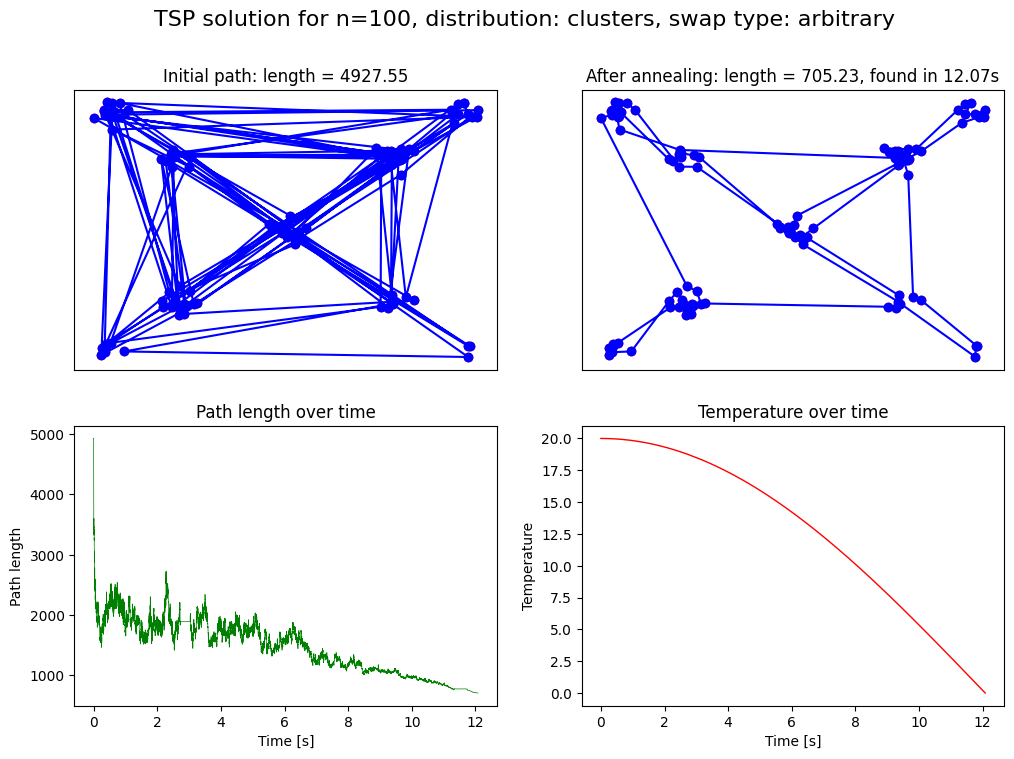

Shortest path comparison for different temperature functions:
T = 0.999T:        591.44, 28.85s
T = T_0(1 - t/12): 567.74, 11.99s
T = T_0cos(0.13t): 705.23, 12.07s



In [9]:
initial_temp = 20
n_values = [20, 50, 100]
distributions = ["uniform", "normal", "clusters"]
temp_functions = {
    "T = 0.999T": lambda x, _: 0.999 * x, 
    "T = T_0(1 - t/12)": lambda _, t: initial_temp * (1 - t / 12),
    "T = T_0cos(0.13t)": lambda _, t: initial_temp * math.cos(t * 0.13),
}

for n in n_values:
    print(f"---------- n = {n} ----------\n")
    for dist in distributions:
        points = generate_points(n, dist)
        results = []

        for temp_fn_name, temp_fn in temp_functions.items():
            start = time.time()
            best_path, best_length, found_time, initial_path, initial_length, lengths, temps, _ =\
                simulated_annealing(points, temperature = initial_temp, temp_function=temp_fn)
            elapsed = time.time() - start

            results.append((temp_fn_name, best_length, found_time))

            print(f"Distribution: {dist}, temperature function: {temp_fn_name}")
            print(f"Initial path length: {initial_length:.2f}")
            print(f"Best path length: {best_length:.2f}, found in {found_time:.2f}s")
            print(f"Total elapsed time: {elapsed:.2f}s")

            plot_results(
                points,
                best_path,
                best_length,
                found_time,
                initial_path,
                initial_length,
                lengths,
                temps,
                n,
                dist,
                "arbitrary"
            )

        print("Shortest path comparison for different temperature functions:") 
        for temp_fn_name, best_length, found_time in results:
            if temp_fn_name == "T = 0.999T":
                print(f"{temp_fn_name}:        {best_length:.2f}, {found_time:.2f}s")
            else:
                print(f"{temp_fn_name}: {best_length:.2f}, {found_time:.2f}s")
        print()
        if dist != "clusters":
            print("--------------------\n")

#### Obserwacje
##### n = 20
- **T = 0.999T**:
  - dużo szybsza niż pozostałe dwie
- **T = T₀(1 - t/12)**:
  - minimalnie szybsza od funkcji cosinusowej
- **T = T₀cos(0.13t)**:
  - najwolniejsza

**Wyniki**:  
Funkcje temperatury znajdowały identyczne (lub bardzo zbliżone) ścieżki, niezależnie od rozkładu punktów.

---

##### n = 50
- **T = 0.999T**:
  - nadal najszybsza, ale różnica w czasie względem pozostałych zmniejszona
  - słabe wyniki jakościowe
- **T = T₀(1 - t/12)**:
  - średnie wyniki i średnia wydajność
- **T = T₀cos(0.13t)**:
  - najlepsze wyniki jakościowe
  - najgorsza wydajność (ale różnice w czasie niewielkie)

**Wyniki**:  
Rezultaty bardziej zróżnicowane niż dla n = 20.

---

##### n = 100
- **T = 0.999T**:
  - zdecydowanie najwolniejsza, wyraźna różnica czasu względem innych funkcji
- **T = T₀(1 - t/12)**:
  - czas działania porównywalny do funkcji cosinusowej
- **T = T₀cos(0.13t)**:
  - czas działania porównywalny do funkcji liniowej

**Wyniki**:  
Przy większej liczbie punktów wyniki były zupełnie inne dla różnych dystrybucji – dla każdej dystrybucji inna funkcja temperatury osiągnęła najlepsze rozwiązanie.

---

#### Wnioski

- Przy małych chmurach punktów (n = 20) funkcja temperatury ma niewielki wpływ na jakość rozwiązania, ale istotnie wpływa na czas działania.
- Dla większych chmur (n = 50, n = 100) funkcje temperatury zaczynają znacząco wpływać na jakość znajdowanych ścieżek.
- Funkcja **T = T₀cos(0.13t)** daje z reguły najlepsze wyniki jakościowe kosztem wydajności.
- Funkcja **T = 0.999T** jest szybka dla małych n, ale skaluje się słabo i daje gorsze wyniki przy większych problemach.
- Dobór funkcji temperatury może wymagać dostosowania do charakterystyki konkretnej instancji problemu (np. dystrybucji punktów).